# Neuroevolution Intuitions

**From Gradient Descent to Evolution-Based Learning**

This notebook builds intuition for neuroevolution - training neural networks without gradients.
We'll start from first principles and work our way up to NEAT and the Evolution Lab implementation.

## Prerequisites
- Familiar with gradient descent and backpropagation
- Know transformers at a high level
- Have heard of grid search, Bayesian optimization
- Can guess GA pseudocode but details are fuzzy

## What You'll Learn
1. Why gradients don't always work
2. How genetic algorithms search solution spaces
3. How to evolve neural network weights
4. The topology evolution problem and NEAT's solution
5. How Evolution Lab implements these concepts

In [1]:
# | export
from utils import set_seed
set_seed(42)

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple, Callable
from dataclasses import dataclass
from copy import deepcopy

%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')

Random seed set to 42


---
# 1. The Problem: Optimization Without Gradients

You know gradient descent: compute $\nabla_{\theta} L$, step in the negative direction, repeat.
It's the workhorse of deep learning. But it has a critical requirement:

**The loss function must be differentiable with respect to the parameters.**

This breaks down in many real-world scenarios.

## 1.1 Why Gradients Fail: A Physics Simulation Example

Imagine you're training a neural network to control a robot in a physics simulation:

```
Neural Net --> Actions --> Physics Engine --> State --> Fitness
   theta        a(t)        [BLACK BOX]       s(t)      f(s)
```

To use backprop, you need $\frac{\partial f}{\partial \theta}$. This requires:

$$\frac{\partial f}{\partial \theta} = \frac{\partial f}{\partial s} \cdot \frac{\partial s}{\partial a} \cdot \frac{\partial a}{\partial \theta}$$

The problem? **Physics engines are non-differentiable black boxes.**

- Collision detection: discrete events (contact or no contact)
- Friction: discontinuous (static vs kinetic)
- Rigid body constraints: inequality constraints

Even if you had access to the source code, computing $\frac{\partial s}{\partial a}$ would require
differentiating through thousands of timesteps of chaotic dynamics.

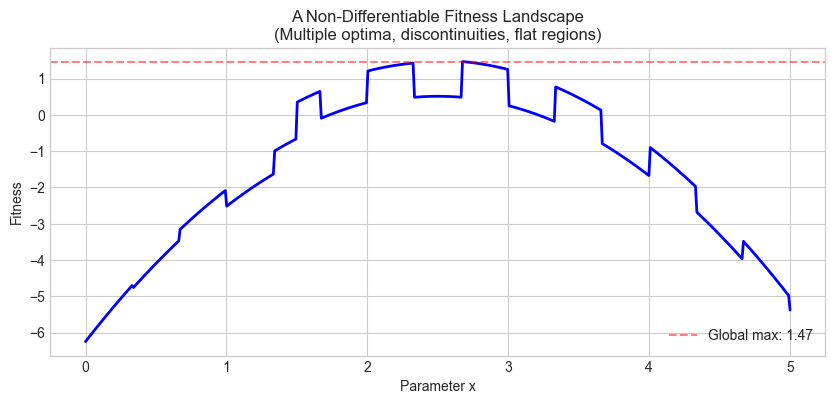

Try computing gradients through torch.floor() - PyTorch will give you zeros!
Gradient of floor(x) at x=2.0: tensor([0.])


In [2]:
# Let's create a simple non-differentiable fitness function
# This simulates the kind of function we face in physics simulations

def physics_fitness(x: torch.Tensor) -> torch.Tensor:
    """
    A fitness function that's impossible to differentiate:
    - Contains discontinuities (floor, sign)
    - Has multiple local optima
    - Simulates 'collision-like' behavior
    """
    # Continuous part (we could differentiate this)
    smooth = -((x - 2.5)**2)
    
    # Non-differentiable parts (these break backprop)
    quantized = torch.floor(x * 3) / 3  # Discretization (like collision grid)
    threshold = torch.where(x > 1.5, torch.ones_like(x), torch.zeros_like(x))  # Step function
    
    # Combine them
    fitness = smooth + 0.5 * torch.sin(quantized * 10) + threshold
    return fitness

# Visualize it
x = torch.linspace(0, 5, 500)
y = physics_fitness(x)

plt.figure(figsize=(10, 4))
plt.plot(x.numpy(), y.numpy(), 'b-', linewidth=2)
plt.xlabel('Parameter x')
plt.ylabel('Fitness')
plt.title('A Non-Differentiable Fitness Landscape\n(Multiple optima, discontinuities, flat regions)')
plt.axhline(y=y.max().item(), color='r', linestyle='--', alpha=0.5, label=f'Global max: {y.max().item():.2f}')
plt.legend()
plt.show()

print("Try computing gradients through torch.floor() - PyTorch will give you zeros!")
x_test = torch.tensor([2.0], requires_grad=True)
y_test = torch.floor(x_test)
y_test.backward()
print(f"Gradient of floor(x) at x=2.0: {x_test.grad}")

## 1.2 Search Strategies Compared

Without gradients, how do we find good solutions? Let's compare approaches.

### Grid Search
- Divide parameter space into a grid
- Evaluate every point
- Scales exponentially: $O(n^d)$ for $n$ points per dimension, $d$ dimensions

### Random Search
- Sample random points
- Keep track of best
- Better than grid for high dimensions (curse of dimensionality)

### Population-Based Search (Genetic Algorithms)
- Maintain a population of solutions
- Good solutions reproduce, bad ones die
- **Key insight**: information flows between solutions via crossover

In [3]:
# | export
def grid_search(fitness_fn: Callable, bounds: Tuple[float, float], n_points: int) -> Tuple[float, float]:
    """Grid search: evaluate fitness at evenly spaced points."""
    x_values = torch.linspace(bounds[0], bounds[1], n_points)
    # import pdb; pdb.set_trace()
    fitnesses = fitness_fn(x_values)
    best_idx = fitnesses.argmax()
    return x_values[best_idx].item(), fitnesses[best_idx].item()

def random_search(fitness_fn: Callable, bounds: Tuple[float, float], n_samples: int) -> Tuple[float, float]:
    """Random search: sample random points uniformly."""
    x_values = torch.rand(n_samples) * (bounds[1] - bounds[0]) + bounds[0]
    fitnesses = fitness_fn(x_values)
    best_idx = fitnesses.argmax()
    return x_values[best_idx].item(), fitnesses[best_idx].item()

In [4]:
import time

# Compare search strategies
bounds = (0.0, 5.0)
n_evals = 50  # Same budget for both

# Time grid search
start_grid = time.time()
grid_result = grid_search(physics_fitness, bounds, n_evals)
end_grid = time.time()
grid_time = end_grid - start_grid

# Time random search (10 trials)
start_random = time.time()
random_results = [random_search(physics_fitness, bounds, n_evals) for _ in range(10)]
end_random = time.time()
random_time = end_random - start_random

print(f"Grid Search (n={n_evals}): x={grid_result[0]:.3f}, fitness={grid_result[1]:.3f} (time: {grid_time:.4f} s)")
print(f"Random Search (n={n_evals}, 10 trials): (time: {random_time:.4f} s)")
print(f"  Best:  fitness={max(r[1] for r in random_results):.3f}")
print(f"  Worst: fitness={min(r[1] for r in random_results):.3f}")
print(f"  Mean:  fitness={sum(r[1] for r in random_results)/10:.3f}")

Grid Search (n=50): x=2.755, fitness=1.435 (time: 0.0005 s)
Random Search (n=50, 10 trials): (time: 0.0004 s)
  Best:  fitness=1.460
  Worst: fitness=0.669
  Mean:  fitness=1.355


## 1.3 The Curse of Dimensionality

With 1 dimension, grid search works fine. But neural networks have thousands to millions of parameters.

Consider a tiny network with just 100 weights:
- Grid search with 10 points per dimension: $10^{100}$ evaluations
- That's more than atoms in the universe ($\approx 10^{80}$)

**We need smarter search strategies.**

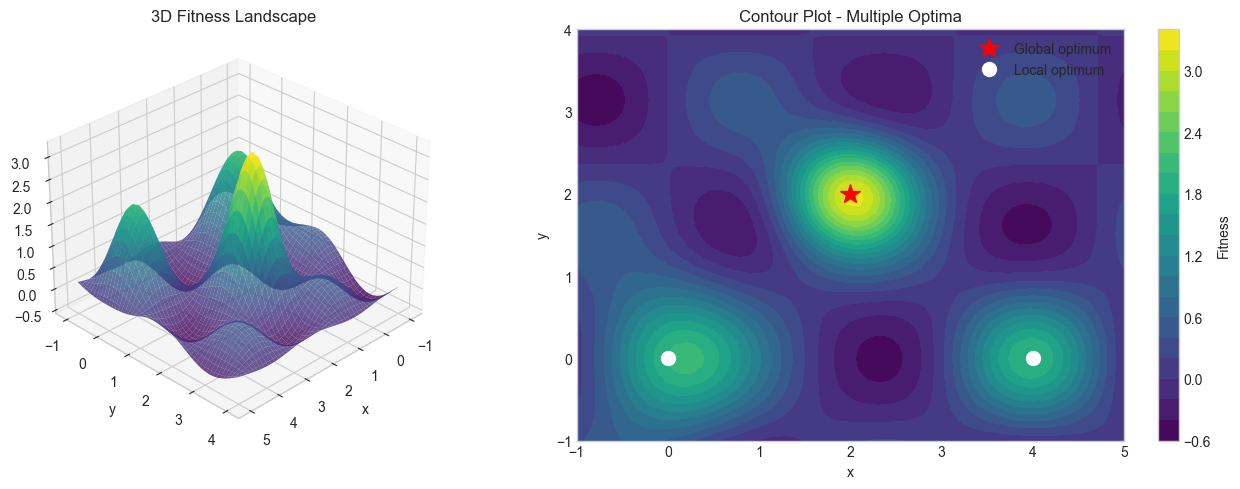

Key insight: Gradient descent starting from (4,0) would get stuck in the local optimum.
Population-based methods explore multiple regions simultaneously.


In [5]:
# Visualize a 2D fitness landscape with multiple optima
def multimodal_fitness_2d(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """A 2D fitne   ss landscape with multiple local optima."""
    # Global optimum near (2, 2)
    # This is a 2D Gaussian "bump" centered at (2, 2), creating a circular hill in the landscape.
    f1 = 3 * torch.exp(-((x - 2)**2 + (y - 2)**2) / 0.5)
    # Local optimum near (0, 0)
    f2 = 2 * torch.exp(-((x)**2 + (y)**2) / 0.8)
    # Local optimum near (4, 0)
    f3 = 1.5 * torch.exp(-((x - 4)**2 + (y)**2) / 0.6)
    # Ridges
    f4 = 0.5 * torch.sin(x * 2) * torch.cos(y * 2)
    return f1 + f2 + f3 + f4

# Create grid for visualization
xx = torch.linspace(-1, 5, 100)
yy = torch.linspace(-1, 4, 100)
X, Y = torch.meshgrid(xx, yy, indexing='ij')
Z = multimodal_fitness_2d(X, Y)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Surface plot
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X.numpy(), Y.numpy(), Z.numpy(), cmap='viridis', alpha=0.8)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('Fitness')
ax1.set_title('3D Fitness Landscape')
ax1.view_init(elev=30, azim=45)
axes[0].remove()  # Remove the original 2D axis

# Contour plot
contour = axes[1].contourf(X.numpy(), Y.numpy(), Z.numpy(), levels=20, cmap='viridis')
plt.colorbar(contour, ax=axes[1], label='Fitness')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].set_title('Contour Plot - Multiple Optima')

# Mark optima
axes[1].plot(2, 2, 'r*', markersize=15, label='Global optimum')
axes[1].plot(0, 0, 'wo', markersize=10, label='Local optimum')
axes[1].plot(4, 0, 'wo', markersize=10)
axes[1].legend()

plt.tight_layout()
plt.show()

print("Key insight: Gradient descent starting from (4,0) would get stuck in the local optimum.")
print("Population-based methods explore multiple regions simultaneously.")

---
# 2. Genetic Algorithms from Scratch

Genetic algorithms (GAs) are inspired by biological evolution:

1. **Population**: Maintain multiple candidate solutions
2. **Selection**: Fitter individuals are more likely to reproduce
3. **Crossover**: Combine genes from two parents
4. **Mutation**: Random changes to explore nearby solutions

Let's build each component from scratch.

## 2.1 Population: Why Many Solutions at Once?

**Point-based search** (gradient descent, hill climbing):
- Maintains a single solution $\theta$
- Updates it iteratively: $\theta_{t+1} = \theta_t - \eta \nabla L$
- Gets stuck in local optima

**Population-based search** (genetic algorithms, evolution strategies):
- Maintains $N$ solutions $\{\theta_1, \theta_2, ..., \theta_N\}$
- Solutions explore different regions simultaneously
- Information flows between solutions via selection and crossover

### The Key Insight

A population is like running N parallel searches that can **share information**:
- If solution A finds a good region, that information propagates to the next generation
- If solution B finds a different good feature, crossover can combine A and B

In [6]:
# | export
@dataclass
class Individual:
    """A single candidate solution in our population."""
    genome: torch.Tensor  # The parameters we're optimizing
    fitness: float = 0.0  # How good is this solution?
    
    def __repr__(self):
        return f"Individual(genome={self.genome.tolist()}, fitness={self.fitness:.4f})"


def create_population(pop_size: int, genome_size: int, 
                       low: float = -5.0, high: float = 5.0) -> List[Individual]:
    """Create a random initial population."""
    population = []
    for _ in range(pop_size):
        genome = torch.rand(genome_size) * (high - low) + low
        population.append(Individual(genome=genome))
    return population

In [7]:
# Create a small population
pop = create_population(pop_size=5, genome_size=2, low=0, high=5)

print("Initial population (random genomes, fitness not yet evaluated):")
for i, ind in enumerate(pop):
    print(f"  {i}: {ind}")

Initial population (random genomes, fitness not yet evaluated):
  0: Individual(genome=[1.8945878744125366, 1.292189359664917], fitness=0.0000)
  1: Individual(genome=[2.9250967502593994, 4.3661208152771], fitness=0.0000)
  2: Individual(genome=[4.454943656921387, 3.6478137969970703], fitness=0.0000)
  3: Individual(genome=[0.6601712107658386, 1.1582380533218384], fitness=0.0000)
  4: Individual(genome=[1.9507215023040771, 2.039189577102661], fitness=0.0000)


## 2.2 Selection: Survival of the Fittest

Selection chooses which individuals get to reproduce. Better fitness = higher chance of being selected.

### Tournament Selection
1. Randomly pick $k$ individuals from the population
2. Return the one with highest fitness
3. Repeat to get multiple parents

**Why tournament?**
- Simple and effective
- Selection pressure controlled by tournament size $k$
- $k=2$: weak pressure (more exploration)
- $k=N$: strong pressure (more exploitation, always picks the best)

### Roulette Wheel Selection (Fitness Proportionate)
1. Selection probability $\propto$ fitness
2. Like spinning a weighted wheel

**Problems with roulette:**
- Requires positive fitness values
- Sensitive to fitness scaling (one very fit individual dominates)

In [8]:
import random  # Need this for the selection functions

# | export
def tournament_selection(population: List[Individual], tournament_size: int = 3):
    """Select one individual using tournament selection. 
    Returns the selected individual and its index in the population.
    """
    indices = random.sample(range(len(population)), min(tournament_size, len(population)))
    tournament = [population[i] for i in indices]
    # Find the winner (max fitness) among the sampled
    winner = max(zip(tournament, indices), key=lambda tup: tup[0].fitness)
    return winner  # (Individual, idx)

def roulette_selection(population: List[Individual]):
    """Select one individual using fitness-proportionate selection.
    Returns the selected individual and its index in the population.
    """
    min_fitness = min(ind.fitness for ind in population)
    shifted = [ind.fitness - min_fitness + 1e-6 for ind in population]
    total = sum(shifted)
    pick = random.random() * total
    current = 0
    for i, (ind, fit) in enumerate(zip(population, shifted)):
        current += fit
        if current >= pick:
            return ind, i
    return population[-1], len(population)-1  # Fallback

In [9]:
# Demonstrate selection
# First, give our population some fitness values
test_pop = create_population(5, 2, 0, 5)
for i, ind in enumerate(test_pop):
    ind.fitness = float(i)  # Fitness: 0, 1, 2, 3, 4

print("Population with fitness values:")
for ind in test_pop:
    print(f"  {ind}")

# Run selection many times to see the distribution
# Count how often each individual is selected by each method
tournament_counts = {i: 0 for i in range(5)}  # Counts for tournament selection
roulette_counts = {i: 0 for i in range(5)}    # Counts for roulette selection

for _ in range(1000):
    # Select individual using tournament selection (k=2)
    selected, idx = tournament_selection(test_pop, tournament_size=2)
    tournament_counts[idx] += 1     # Increment count for that individual
    
    # Select individual using roulette (fitness-proportionate) selection
    selected, idx = roulette_selection(test_pop)
    roulette_counts[idx] += 1       # Increment count for that individual

print("\nSelection distribution (1000 trials):")
print("Fitness | Tournament(k=2) | Roulette")
print("-" * 40)
for i in range(5):
    print(f"   {i}    |      {tournament_counts[i]:4d}       |   {roulette_counts[i]:4d}")

print("\nNote: Higher fitness = selected more often")

Population with fitness values:
  Individual(genome=[2.7056193351745605, 0.20507127046585083], fitness=0.0000)
  Individual(genome=[3.2781119346618652, 0.5928197503089905], fitness=1.0000)
  Individual(genome=[0.918138325214386, 0.4215437173843384], fitness=2.0000)
  Individual(genome=[4.6782989501953125, 0.1326504349708557], fitness=3.0000)
  Individual(genome=[4.385916709899902, 2.4159576892852783], fitness=4.0000)

Selection distribution (1000 trials):
Fitness | Tournament(k=2) | Roulette
----------------------------------------
   0    |         0       |      0
   1    |        86       |     93
   2    |       207       |    202
   3    |       303       |    311
   4    |       404       |    394

Note: Higher fitness = selected more often


## Tournament Selection: Why It's Popular

**Pros:**
- **Scale-free:** Unaffected by the absolute values of fitness; only relative ranking matters.
- **Robust:** Works well even when fitness values are noisy, badly scaled, or negative.
- **Tunable Pressure:** Easily adjust selection pressure by changing the tournament size ($k$).
- **Widely Used:** The go-to method in modern evolutionary algorithms.

**Cons:**
- **Loss of Diversity:** Lower-fitness individuals may be eliminated quickly.
- **Premature Convergence Risk:** Higher selection pressure can reduce exploration.
- **Excludes the Weak:** Some individuals get zero chance if always outcompeted.

---

## Roulette (Fitness-Proportionate) Selection: Why It's Less Favored

**Pros:**
- **Smooth Selection:** Probability of selection changes continuously with fitness.
- **Inclusive:** Every individual always has a nonzero chance to be selected.
- **Intuitive:** Simple idea—more fit means more likely to reproduce.

**Cons:**
- **Scaling Sensitivity:** Highly dependent on absolute fitness values; can behave badly if all are similar or noisy.
- **Dominance by Outliers:** One extremely fit individual can monopolize selection.
- **Requires Tweaks:** Often needs shifting, scaling, or normalization to function well. 


In [10]:
import random
from typing import List, Tuple

# --- Existing dataclass from you ---
# @dataclass
# class Individual:
#     genome: torch.Tensor
#     fitness: float = 0.0

# -----------------------------
# Selection functions (return both (selected_individual, index_in_population))
# -----------------------------


def rank_selection(population: List["Individual"], selective_pressure: float = 1.7) -> Tuple["Individual", int]:
    """
    Rank-based selection (linear ranking):
      - Sort by fitness (worst..best)
      - Assign weights by rank, not raw fitness.
    selective_pressure in [1, 2] is typical:
      - 1.0 => almost uniform
      - 2.0 => strong pressure
    """
    n = len(population)
    assert n > 0
    s = max(1.0, min(2.0, selective_pressure))

    # Sort indices by fitness ascending (rank 1 = worst, rank n = best)
    sorted_idxs = sorted(range(n), key=lambda i: population[i].fitness)

    # Linear ranking weights (Baker 1985 style):
    # expected copies for rank r (1..n): w_r = (2 - s)/n + 2*(r-1)*(s-1)/(n*(n-1))
    # This ensures weights sum to 1.
    weights = []
    for r in range(1, n + 1):
        w = (2 - s) / n + (2 * (r - 1) * (s - 1)) / (n * (n - 1) if n > 1 else 1)
        weights.append(w)

    # Roulette over ranks, then map back to original index
    pick = random.random()
    cum = 0.0
    for rank_pos, w in enumerate(weights):  # rank_pos 0..n-1 corresponds to r=1..n
        cum += w
        if cum >= pick:
            chosen_idx = sorted_idxs[rank_pos]
            return population[chosen_idx], chosen_idx

    chosen_idx = sorted_idxs[-1]
    return population[chosen_idx], chosen_idx


def truncation_selection(population: List["Individual"], top_frac: float = 0.4) -> Tuple["Individual", int]:
    """
    Truncation selection:
      - Keep only the top X% by fitness
      - Select uniformly from that elite set
    """
    n = len(population)
    assert n > 0
    top_k = max(1, int(round(n * top_frac)))

    sorted_idxs = sorted(range(n), key=lambda i: population[i].fitness, reverse=True)
    elite = sorted_idxs[:top_k]

    chosen_idx = random.choice(elite)
    return population[chosen_idx], chosen_idx


def stochastic_universal_sampling(population: List["Individual"]) -> Tuple["Individual", int]:
    """
    SUS (Stochastic Universal Sampling):
    Like roulette but with evenly spaced pointers; typically used to sample *multiple*
    parents with lower variance. Here we show single-sample form for comparison.
    """
    min_fitness = min(ind.fitness for ind in population)
    shifted = [ind.fitness - min_fitness + 1e-6 for ind in population]
    total = sum(shifted)

    # Single pointer version (multi-pointer SUS is where it shines)
    pointer = random.random() * total
    cum = 0.0
    for i, w in enumerate(shifted):
        cum += w
        if cum >= pointer:
            return population[i], i
    return population[-1], len(population) - 1


# -----------------------------
# Demonstrate selection distributions (same style as your table)
# -----------------------------

# test_pop = create_population(5, 2, 0, 5)
# for i, ind in enumerate(test_pop):
#     ind.fitness = float(i)  # Fitness: 0, 1, 2, 3, 4

def demo_selection_table(test_pop: List["Individual"], trials: int = 1000) -> None:
    # Counts by fitness index (0..4)
    counts = {
        "Tournament(k=2)": {i: 0 for i in range(len(test_pop))},
        "Roulette": {i: 0 for i in range(len(test_pop))},
        "Rank": {i: 0 for i in range(len(test_pop))},
        "Trunc(top40%)": {i: 0 for i in range(len(test_pop))},
        "SUS": {i: 0 for i in range(len(test_pop))}
    }

    for _ in range(trials):
        _, idx = tournament_selection(test_pop, tournament_size=2)
        counts["Tournament(k=2)"][idx] += 1

        _, idx = roulette_selection(test_pop)
        counts["Roulette"][idx] += 1

        _, idx = rank_selection(test_pop, selective_pressure=1.7)
        counts["Rank"][idx] += 1

        _, idx = truncation_selection(test_pop, top_frac=0.4)
        counts["Trunc(top40%)"][idx] += 1

        _, idx = stochastic_universal_sampling(test_pop)
        counts["SUS"][idx] += 1

    print("Population with fitness values:")
    for ind in test_pop:
        print(f"  {ind}")

    print(f"\nSelection distribution ({trials} trials):")
    header = "Fitness | Tournament(k=2) | Roulette | Rank | Trunc(top40%) | SUS"
    print(header)
    print("-" * len(header))

    for i in range(len(test_pop)):
        print(
            f"   {i}    |"
            f"      {counts['Tournament(k=2)'][i]:4d}      |"
            f"  {counts['Roulette'][i]:4d}   |"
            f" {counts['Rank'][i]:4d} |"
            f"     {counts['Trunc(top40%)'][i]:4d}      |"
            f" {counts['SUS'][i]:4d}"
        )

    print("\nNote: Higher fitness = selected more often")


# Example usage:
demo_selection_table(test_pop, trials=1000)



Population with fitness values:
  Individual(genome=[2.7056193351745605, 0.20507127046585083], fitness=0.0000)
  Individual(genome=[3.2781119346618652, 0.5928197503089905], fitness=1.0000)
  Individual(genome=[0.918138325214386, 0.4215437173843384], fitness=2.0000)
  Individual(genome=[4.6782989501953125, 0.1326504349708557], fitness=3.0000)
  Individual(genome=[4.385916709899902, 2.4159576892852783], fitness=4.0000)

Selection distribution (1000 trials):
Fitness | Tournament(k=2) | Roulette | Rank | Trunc(top40%) | SUS
-----------------------------------------------------------------
   0    |         0      |     0   |   64 |        0      |    0
   1    |       102      |    98   |  128 |        0      |   99
   2    |       200      |   198   |  203 |        0      |  210
   3    |       274      |   307   |  267 |      480      |  301
   4    |       424      |   397   |  338 |      520      |  390

Note: Higher fitness = selected more often


All five are ways to trade off selection pressure vs diversity under noisy, nonconvex fitness. Tournament is popular because it’s simple, fast, and scale-robust (it depends on relative ranking, not fitness magnitudes) and you can tune pressure with k. Roulette (fitness-proportionate) is conceptually intuitive but brittle: fitness scaling/outliers can dominate, so it’s less common in modern practice. Rank selection fixes roulette’s brittleness by using ordering rather than raw values, giving more stable pressure when fitness distributions change across generations. Truncation is very strong pressure (pick only the top slice), which can accelerate progress early but risks premature convergence and loss of diversity. SUS is a lower-variance version of roulette when sampling many parents at once; it reduces randomness in who gets picked (helpful when you want the expected proportions more reliably), though it still inherits roulette’s sensitivity to fitness scaling unless you rank/normalize first.

## 2.3 Mutation: Exploring Nearby Solutions

Mutation introduces random changes to a genome. This is how GAs **explore** the search space.

### Gaussian Mutation
For continuous parameters (like neural network weights):

$$\theta'_i = \theta_i + \mathcal{N}(0, \sigma^2) \quad \text{with probability } p_{mut}$$

**Key parameters:**
- $p_{mut}$: probability each gene mutates (exploration rate)
- $\sigma$: mutation magnitude (step size)

**Intuition:**
- Small $\sigma$: fine-tuning, local search
- Large $\sigma$: big jumps, escaping local optima

In [13]:
# | export
def mutate(individual: Individual, mutation_rate: float = 0.1, 
           mutation_magnitude: float = 0.3) -> Individual:
    """
    Apply Gaussian mutation to an individual.
    
    Args:
        individual: The individual to mutate
        mutation_rate: Probability each gene mutates
        mutation_magnitude: Standard deviation of Gaussian noise
    
    Returns:
        A new mutated individual (original is not modified)
    """
    new_genome = individual.genome.clone()
    print(new_genome)
    
    # Create mutation mask (which genes to mutate)
    # For each gene, randomly decide if it should mutate (True with probability = mutation_rate)
    mask = torch.rand(new_genome.shape) < mutation_rate  # (True where mutation occurs)
    print(mask)
    
    # Apply Gaussian noise where mask is True
    noise = torch.randn(new_genome.shape) * mutation_magnitude
    print(noise)
    new_genome = new_genome + mask.float() * noise
    print(new_genome)
    
    return Individual(genome=new_genome)

tensor([2.5000, 2.5000])
tensor([True, True])
tensor([-0.0264, -0.1677])
tensor([2.4736, 2.3323])
tensor([2.5000, 2.5000])
tensor([True, True])
tensor([ 0.0998, -0.3119])
tensor([2.5998, 2.1881])
tensor([2.5000, 2.5000])
tensor([True, True])
tensor([-0.0977,  0.1391])
tensor([2.4023, 2.6391])
tensor([2.5000, 2.5000])
tensor([True, True])
tensor([0.0008, 0.1836])
tensor([2.5008, 2.6836])
tensor([2.5000, 2.5000])
tensor([True, True])
tensor([-0.1459, -0.3069])
tensor([2.3541, 2.1931])
tensor([2.5000, 2.5000])
tensor([True, True])
tensor([-0.1158,  0.0232])
tensor([2.3842, 2.5232])
tensor([2.5000, 2.5000])
tensor([True, True])
tensor([0.4055, 0.2054])
tensor([2.9055, 2.7054])
tensor([2.5000, 2.5000])
tensor([True, True])
tensor([0.2685, 0.2328])
tensor([2.7685, 2.7328])
tensor([2.5000, 2.5000])
tensor([True, True])
tensor([-0.1889, -0.0157])
tensor([2.3111, 2.4843])
tensor([2.5000, 2.5000])
tensor([True, True])
tensor([ 0.0485, -0.4521])
tensor([2.5485, 2.0479])
tensor([2.5000, 2.5000])
t

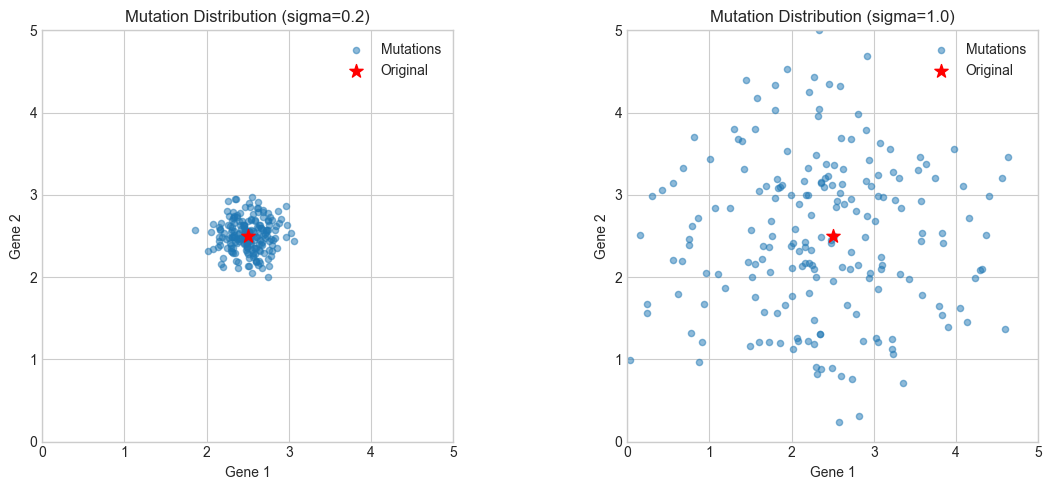

Small sigma: fine local search. Large sigma: broader exploration.


In [14]:
# Visualize mutation
original = Individual(genome=torch.tensor([2.5, 2.5]))

# Generate many mutations
mutations_low_sigma = [mutate(original, mutation_rate=1.0, mutation_magnitude=0.2) for _ in range(200)]
mutations_high_sigma = [mutate(original, mutation_rate=1.0, mutation_magnitude=1.0) for _ in range(200)]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, mutations, sigma in [(axes[0], mutations_low_sigma, 0.2), 
                              (axes[1], mutations_high_sigma, 1.0)]:
    xs = [m.genome[0].item() for m in mutations]
    ys = [m.genome[1].item() for m in mutations]
    
    ax.scatter(xs, ys, alpha=0.5, s=20, label='Mutations')
    ax.scatter([2.5], [2.5], c='red', s=100, marker='*', label='Original', zorder=5)
    ax.set_xlim(0, 5)
    ax.set_ylim(0, 5)
    ax.set_xlabel('Gene 1')
    ax.set_ylabel('Gene 2')
    ax.set_title(f'Mutation Distribution (sigma={sigma})')
    ax.legend()
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()

print("Small sigma: fine local search. Large sigma: broader exploration.")

## 2.4 Crossover: Combining Good Solutions

Crossover creates offspring by combining genes from two parents.

**Why crossover matters:**
- Parent A might have good genes at positions [0, 1]
- Parent B might have good genes at positions [2, 3]
- Offspring could inherit the best of both!

### Types of Crossover

**Single-point crossover:**
```
Parent A: [a0, a1, | a2, a3]    -->   Child 1: [a0, a1, b2, b3]
Parent B: [b0, b1, | b2, b3]    -->   Child 2: [b0, b1, a2, a3]
```

**Uniform crossover:**
```
Each gene independently chosen from either parent with 50% probability
```

**Blend crossover (for continuous):**
```
child[i] = alpha * parent_a[i] + (1-alpha) * parent_b[i]
```

In [15]:
# | export
def crossover_uniform(parent_a: Individual, parent_b: Individual) -> Tuple[Individual, Individual]:
    """
    Uniform crossover: each gene randomly from either parent.
    Returns two children.
    """
    mask = torch.rand(parent_a.genome.shape) < 0.5
    
    child1_genome = torch.where(mask, parent_a.genome, parent_b.genome)
    child2_genome = torch.where(mask, parent_b.genome, parent_a.genome)
    
    return Individual(genome=child1_genome), Individual(genome=child2_genome)


def crossover_blend(parent_a: Individual, parent_b: Individual, 
                    alpha: float = 0.5) -> Individual:
    """
    Blend crossover: interpolate between parents.
    alpha=0.5 gives the midpoint.
    """
    child_genome = alpha * parent_a.genome + (1 - alpha) * parent_b.genome
    return Individual(genome=child_genome)

In [16]:
# Demonstrate crossover
parent_a = Individual(genome=torch.tensor([1.0, 1.0, 1.0, 1.0]))
parent_b = Individual(genome=torch.tensor([9.0, 9.0, 9.0, 9.0]))

print(f"Parent A: {parent_a.genome.tolist()}")
print(f"Parent B: {parent_b.genome.tolist()}")
print()

# Uniform crossover
child1, child2 = crossover_uniform(parent_a, parent_b)
print(f"Uniform crossover:")
print(f"  Child 1: {child1.genome.tolist()}")
print(f"  Child 2: {child2.genome.tolist()}")
print()

# Blend crossover
child_blend = crossover_blend(parent_a, parent_b, alpha=0.5)
print(f"Blend crossover (alpha=0.5):")
print(f"  Child: {child_blend.genome.tolist()}")

Parent A: [1.0, 1.0, 1.0, 1.0]
Parent B: [9.0, 9.0, 9.0, 9.0]

Uniform crossover:
  Child 1: [9.0, 1.0, 1.0, 9.0]
  Child 2: [1.0, 9.0, 9.0, 1.0]

Blend crossover (alpha=0.5):
  Child: [5.0, 5.0, 5.0, 5.0]


## 2.5 Complete GA Implementation

Now let's put it all together into a complete genetic algorithm.

In [19]:
# | export
def evaluate_population(population: List[Individual], 
                        fitness_fn: Callable[[torch.Tensor], float]) -> None:
    """Evaluate fitness for all individuals in place."""
    for ind in population:
        ind.fitness = fitness_fn(ind.genome)


def genetic_algorithm(
    fitness_fn: Callable[[torch.Tensor], float],
    genome_size: int,
    pop_size: int = 50,
    generations: int = 100,
    mutation_rate: float = 0.1,
    mutation_magnitude: float = 0.3,
    crossover_rate: float = 0.8,
    tournament_size: int = 3,
    elitism: int = 2,
    bounds: Tuple[float, float] = (-5.0, 5.0),
    verbose: bool = True
) -> Tuple[Individual, List[dict]]:
    """
    Run a genetic algorithm to maximize fitness_fn.
    
    Args:
        fitness_fn: Function mapping genome tensor to scalar fitness
        genome_size: Number of genes per individual
        pop_size: Population size
        generations: Number of generations to run
        mutation_rate: Probability each gene mutates
        mutation_magnitude: Std dev of mutation noise
        crossover_rate: Probability of crossover vs cloning
        tournament_size: Size of selection tournaments
        elitism: Number of best individuals to preserve unchanged
        bounds: (low, high) bounds for initial population
        verbose: Print progress
    
    Returns:
        best_individual: The best solution found
        history: List of generation statistics
    """
    # Initialize population
    population = create_population(pop_size, genome_size, bounds[0], bounds[1])
    evaluate_population(population, fitness_fn)
    
    history = []
    
    for gen in range(generations):
        # Sort by fitness (best first)
        population.sort(key=lambda ind: ind.fitness, reverse=True)
        
        # Record statistics
        fitnesses = [ind.fitness for ind in population]
        history.append({
            'generation': gen,
            'best_fitness': fitnesses[0],
            'mean_fitness': sum(fitnesses) / len(fitnesses),
            'worst_fitness': fitnesses[-1],
            'best_genome': population[0].genome.clone()
        })
        
        if verbose and gen % 10 == 0:
            print(f"Gen {gen:3d}: best={fitnesses[0]:.4f}, mean={history[-1]['mean_fitness']:.4f}")
        
        # Create next generation
        next_population = []
        
        # Elitism: preserve best individuals
        for i in range(elitism):
            elite = Individual(genome=population[i].genome.clone())
            elite.fitness = population[i].fitness
            next_population.append(elite)
        
        # Fill rest with offspring
        while len(next_population) < pop_size:
            # Selection
            parent_a, _ = tournament_selection(population, tournament_size)
            parent_b, _ = tournament_selection(population, tournament_size)
            
            # Crossover or clone
            if random.random() < crossover_rate:
                child1, child2 = crossover_uniform(parent_a, parent_b)
            else:
                child1 = Individual(genome=parent_a.genome.clone())
                child2 = Individual(genome=parent_b.genome.clone())
            
            # Mutation
            child1 = mutate(child1, mutation_rate, mutation_magnitude)
            child2 = mutate(child2, mutation_rate, mutation_magnitude)
            
            next_population.append(child1)
            if len(next_population) < pop_size:
                next_population.append(child2)
        
        # Evaluate new population
        population = next_population
        evaluate_population(population, fitness_fn)
    
    # Final evaluation
    population.sort(key=lambda ind: ind.fitness, reverse=True)
    return population[0], history

In [20]:
# Test on our 2D multimodal function
def fitness_2d(genome: torch.Tensor) -> float:
    """Fitness function for 2D optimization."""
    return multimodal_fitness_2d(genome[0], genome[1]).item()

set_seed(42)
best, history = genetic_algorithm(
    fitness_fn=fitness_2d,
    genome_size=2,
    pop_size=30,
    generations=50,
    mutation_rate=0.2,
    mutation_magnitude=0.5,
    bounds=(-1.0, 5.0)
)

print(f"\nBest solution: x={best.genome[0]:.4f}, y={best.genome[1]:.4f}")
print(f"Best fitness: {best.fitness:.4f}")
print(f"Expected optimum: x=2.0, y=2.0")

Random seed set to 42
Gen   0: best=1.5129, mean=0.3092
tensor([ 2.3280, -0.1315])
tensor([False, False])
tensor([0.0666, 0.4320])
tensor([ 2.3280, -0.1315])
tensor([4.3478, 1.0539])
tensor([False, False])
tensor([-0.7945, -0.5604])
tensor([4.3478, 1.0539])
tensor([ 4.6446, -0.2009])
tensor([ True, False])
tensor([-1.0628,  0.4814])
tensor([ 3.5818, -0.2009])
tensor([0.5394, 3.7618])
tensor([False, False])
tensor([-0.3705,  0.1809])
tensor([0.5394, 3.7618])
tensor([4.3478, 0.6170])
tensor([False, False])
tensor([-0.1708,  0.1520])
tensor([4.3478, 0.6170])
tensor([-0.3681, -0.1315])
tensor([False, False])
tensor([-0.6841, -0.3870])
tensor([-0.3681, -0.1315])
tensor([ 4.3478, -0.1315])
tensor([False,  True])
tensor([-0.4614, -0.3645])
tensor([ 4.3478, -0.4960])
tensor([0.5394, 3.7618])
tensor([False, False])
tensor([0.0526, 0.4802])
tensor([0.5394, 3.7618])
tensor([4.3478, 1.9478])
tensor([False, False])
tensor([0.7990, 0.0557])
tensor([4.3478, 1.9478])
tensor([ 2.9488, -0.1315])
tensor(

## 2.6 Visualizing Population Evolution

Let's watch how the population explores and converges over generations.

In [22]:
# Run GA again but save population snapshots
def ga_with_snapshots(
    fitness_fn: Callable,
    genome_size: int = 2,
    pop_size: int = 30,
    generations: int = 50,
    bounds: Tuple[float, float] = (-1.0, 5.0)
):
    """GA that saves population snapshots for visualization."""
    population = create_population(pop_size, genome_size, bounds[0], bounds[1])
    evaluate_population(population, fitness_fn)
    
    snapshots = []
    
    for gen in range(generations):
        # Save snapshot
        snapshots.append([
            (ind.genome[0].item(), ind.genome[1].item(), ind.fitness)
            for ind in population
        ])
        
        # Standard GA operations
        population.sort(key=lambda ind: ind.fitness, reverse=True)
        next_pop = [Individual(genome=population[0].genome.clone())]  # Elitism
        
        while len(next_pop) < pop_size:
            p_a, _ = tournament_selection(population, 3)
            p_b, _ = tournament_selection(population, 3)
            c1, c2 = crossover_uniform(p_a, p_b)
            c1 = mutate(c1, 0.2, 0.5)
            c2 = mutate(c2, 0.2, 0.5)
            next_pop.extend([c1, c2])
        
        population = next_pop[:pop_size]
        evaluate_population(population, fitness_fn)
    
    return snapshots

set_seed(42)
snapshots = ga_with_snapshots(fitness_2d)

Random seed set to 42
tensor([ 2.3280, -0.1315])
tensor([False, False])
tensor([0.0666, 0.4320])
tensor([ 2.3280, -0.1315])
tensor([4.3478, 1.0539])
tensor([False, False])
tensor([-0.7945, -0.5604])
tensor([4.3478, 1.0539])
tensor([1.3427, 2.6054])
tensor([ True, False])
tensor([-1.0628,  0.4814])
tensor([0.2799, 2.6054])
tensor([ 4.6446, -0.2009])
tensor([False, False])
tensor([-0.3705,  0.1809])
tensor([ 4.6446, -0.2009])
tensor([-0.3681,  0.1715])
tensor([False, False])
tensor([-0.1708,  0.1520])
tensor([-0.3681,  0.1715])
tensor([3.5235, 0.6170])
tensor([False, False])
tensor([-0.6841, -0.3870])
tensor([3.5235, 0.6170])
tensor([ 4.3478, -0.1315])
tensor([False,  True])
tensor([-0.4614, -0.3645])
tensor([ 4.3478, -0.4960])
tensor([2.3280, 1.0539])
tensor([False, False])
tensor([0.0526, 0.4802])
tensor([2.3280, 1.0539])
tensor([ 0.5394, -0.1315])
tensor([False, False])
tensor([0.7990, 0.0557])
tensor([ 0.5394, -0.1315])
tensor([4.3478, 3.7618])
tensor([ True, False])
tensor([-0.3182,

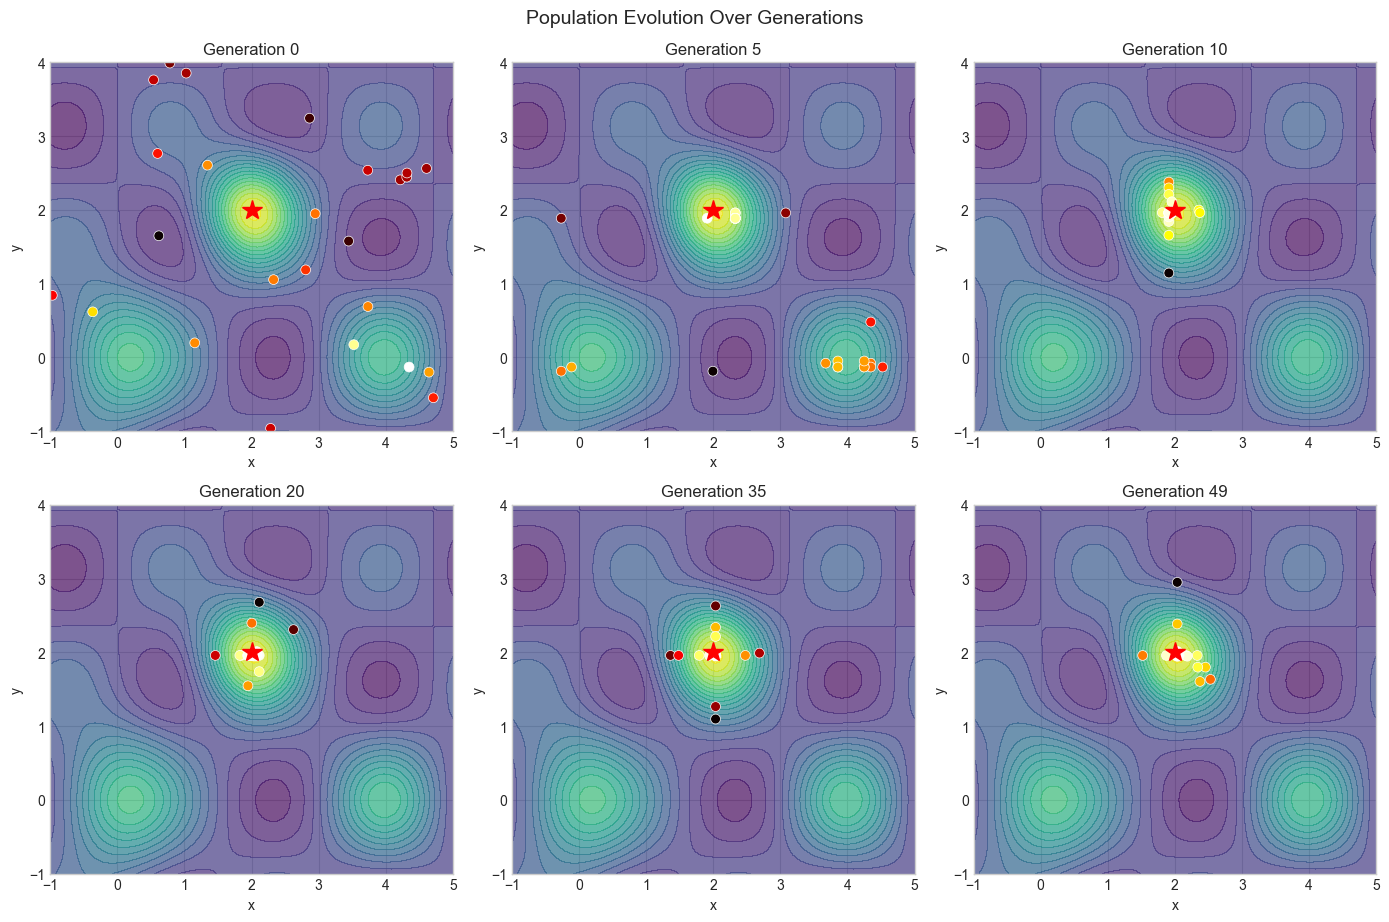

Observe: Population starts spread out, then converges to the global optimum.


In [23]:
# Visualize selected generations
fig, axes = plt.subplots(2, 3, figsize=(14, 9))
gen_indices = [0, 5, 10, 20, 35, 49]

for ax, gen_idx in zip(axes.flat, gen_indices):
    # Draw fitness landscape
    ax.contourf(X.numpy(), Y.numpy(), Z.numpy(), levels=20, cmap='viridis', alpha=0.7)
    
    # Draw population
    snapshot = snapshots[gen_idx]
    xs = [s[0] for s in snapshot]
    ys = [s[1] for s in snapshot]
    fits = [s[2] for s in snapshot]
    
    # Color by fitness
    scatter = ax.scatter(xs, ys, c=fits, cmap='hot', s=50, edgecolor='white', linewidth=0.5)
    
    ax.set_xlim(-1, 5)
    ax.set_ylim(-1, 4)
    ax.set_title(f'Generation {gen_idx}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.plot(2, 2, 'r*', markersize=15)  # Mark optimum

plt.tight_layout()
plt.suptitle('Population Evolution Over Generations', y=1.02, fontsize=14)
plt.show()

print("Observe: Population starts spread out, then converges to the global optimum.")

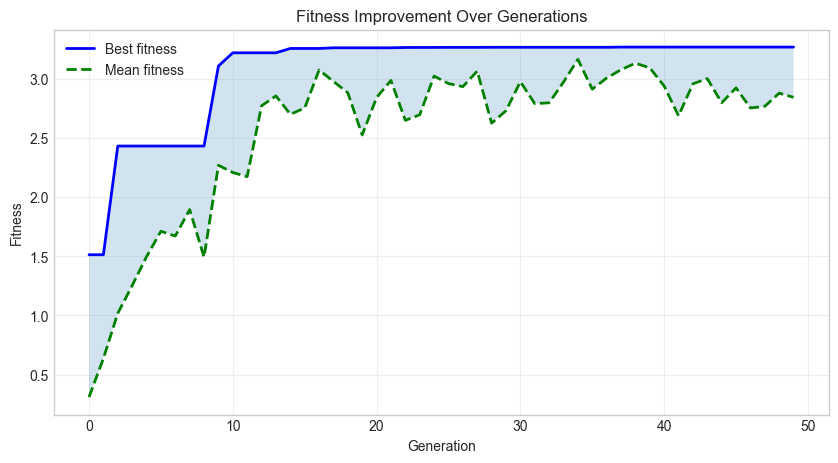

In [24]:
# Plot fitness over generations
fig, ax = plt.subplots(figsize=(10, 5))

gens = [h['generation'] for h in history]
best_fits = [h['best_fitness'] for h in history]
mean_fits = [h['mean_fitness'] for h in history]

ax.plot(gens, best_fits, 'b-', linewidth=2, label='Best fitness')
ax.plot(gens, mean_fits, 'g--', linewidth=2, label='Mean fitness')
ax.fill_between(gens, mean_fits, best_fits, alpha=0.2)

ax.set_xlabel('Generation')
ax.set_ylabel('Fitness')
ax.set_title('Fitness Improvement Over Generations')
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()

## Practice Problem 1: Tune GA Parameters

Try different GA parameters and see how they affect convergence.

In [26]:
# TODO: Fill in the parameters to make the GA converge faster
# Hint: Consider population size, mutation rate, and tournament size

set_seed(123)

# Fill in these parameters:
my_pop_size = 110  # fill in code here
my_mutation_rate = 0.2  # fill in code here  
my_mutation_magnitude = 0.35  # fill in code here
my_tournament_size = 2  # fill in code here

best, hist = genetic_algorithm(
    fitness_fn=fitness_2d,
    genome_size=2,
    pop_size=my_pop_size,
    generations=30,  # Try to reach optimum in fewer generations
    mutation_rate=my_mutation_rate,
    mutation_magnitude=my_mutation_magnitude,
    tournament_size=my_tournament_size,
    bounds=(-1.0, 5.0),
    verbose=True
)

print(f"\nFinal fitness: {best.fitness:.4f}")
assert best.fitness > 2.5, f"Fitness should be > 2.5, got {best.fitness:.4f}"
print("Success!")

Random seed set to 123
Gen   0: best=3.1900, mean=0.4020
tensor([-0.2255, -0.2550])
tensor([False, False])
tensor([-0.0532,  0.0528])
tensor([-0.2255, -0.2550])
tensor([ 4.2856, -0.3497])
tensor([False, False])
tensor([-0.0175,  0.7114])
tensor([ 4.2856, -0.3497])
tensor([-0.0435,  2.4716])
tensor([False, False])
tensor([0.1301, 0.1410])
tensor([-0.0435,  2.4716])
tensor([1.5321, 0.2791])
tensor([ True, False])
tensor([0.9776, 0.1130])
tensor([2.5097, 0.2791])
tensor([-0.2255, -0.2550])
tensor([False, False])
tensor([-0.5992,  0.2109])
tensor([-0.2255, -0.2550])
tensor([2.6252, 4.9016])
tensor([False,  True])
tensor([-0.1244, -0.2258])
tensor([2.6252, 4.6758])
tensor([0.8198, 4.9016])
tensor([False, False])
tensor([-0.0670,  0.2583])
tensor([0.8198, 4.9016])
tensor([2.6252, 2.6360])
tensor([False, False])
tensor([-0.0249,  0.7569])
tensor([2.6252, 2.6360])
tensor([2.0546, 2.0605])
tensor([False, False])
tensor([ 0.0794, -0.1694])
tensor([2.0546, 2.0605])
tensor([ 4.2856, -0.3497])
tens

---
# 3. From Numbers to Neural Networks

Now for the key insight: **a neural network is just a vector of numbers (weights and biases)**.

If we can evolve a vector of 2 numbers to optimize a fitness function,
we can evolve a vector of 1000 numbers (neural network weights) the same way.

## 3.1 A Neural Network as a Flat Vector

Consider a simple network:
```
Input (2) --> Hidden (3) --> Output (1)
```

Parameters:
- W1: 2x3 = 6 weights
- b1: 3 biases
- W2: 3x1 = 3 weights  
- b2: 1 bias
- **Total: 13 parameters**

We can flatten these into a single vector `[w1_00, w1_01, ..., b2_0]` and evolve it!

In [31]:
# | export
class EvolvableNetwork(nn.Module):
    """
    A neural network that can be evolved (genome = flattened weights).
    """
    
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def get_genome(self) -> torch.Tensor:
        """Flatten all parameters into a single vector."""
        # torch.cat concatenates a sequence of tensors along a given dimension.
        # Here, we flatten each parameter tensor to 1D with .view(-1), then concatenate them all into one long 1D tensor.
        params = [param.data.view(-1) for param in self.parameters()]
        return torch.cat(params, dim=0)
    
    def set_genome(self, genome: torch.Tensor) -> None:
        """Set parameters from a flattened vector."""
        idx = 0
        for param in self.parameters():
            size = param.numel()
            # The line below sets the underlying data of the parameter tensor
            # to values taken from the genome vector. It reshapes the selected
            # slice of the flat genome (of length `size`) to the shape of the parameter,
            # then clones it (to detach from genome's storage), and assigns it to param.data,
            # replacing the weights in-place without changing the tensor object itself.
            print("param.data", param.data)
            print("param.shape", param.shape)
            print("idx", idx)
            print("size", size)
            print("genome[idx:idx+size]", genome[idx:idx+size])
            param.data = genome[idx:idx+size].view(param.shape).clone()
            print("param.data", param.data)
            idx += size
    
    def genome_size(self) -> int:
        """Total number of parameters."""
        return sum(p.numel() for p in self.parameters())

In [32]:
# Demonstrate genome extraction and setting
net = EvolvableNetwork(input_size=2, hidden_size=3, output_size=1)

print(f"Network architecture: 2 -> 3 -> 1")
print(f"Total parameters: {net.genome_size()}")
print()

# Extract genome
genome = net.get_genome()
print(f"Genome shape: {genome.shape}")
print(f"Genome values: {genome[:10].tolist()}...")  # First 10
print()

# Test forward pass
x = torch.tensor([[1.0, 0.5]])
y = net(x)
print(f"Input: {x.tolist()}")
print(f"Output: {y.item():.4f}")

Network architecture: 2 -> 3 -> 1
Total parameters: 13

Genome shape: torch.Size([13])
Genome values: [0.5042245984077454, 0.6035749912261963, -0.6961685419082642, -0.1543646901845932, -0.33842965960502625, -0.4683529734611511, -0.2907157242298126, -0.31281644105911255, 0.3514940142631531, 0.496304988861084]...

Input: [[1.0, 0.5]]
Output: 0.2614


In [33]:
# Show that modifying genome changes network behavior
print("Original output:", net(x).item())

# Modify genome
new_genome = genome.clone()
new_genome[:] = 1.0  # Set all weights to 1.0
net.set_genome(new_genome)

print("After setting all weights to 1.0:", net(x).item())

# Random genome
random_genome = torch.randn(net.genome_size())
net.set_genome(random_genome)
print("After random genome:", net(x).item())

Original output: 0.2613564431667328
param.data tensor([[ 0.5042,  0.6036],
        [-0.6962, -0.1544],
        [-0.3384, -0.4684]])
param.shape torch.Size([3, 2])
idx 0
size 6
genome[idx:idx+size] tensor([1., 1., 1., 1., 1., 1.])
param.data tensor([[1., 1.],
        [1., 1.],
        [1., 1.]])
param.data tensor([-0.2907, -0.3128,  0.3515])
param.shape torch.Size([3])
idx 6
size 3
genome[idx:idx+size] tensor([1., 1., 1.])
param.data tensor([1., 1., 1.])
param.data tensor([[ 0.4963, -0.3109, -0.5578]])
param.shape torch.Size([1, 3])
idx 9
size 3
genome[idx:idx+size] tensor([1., 1., 1.])
param.data tensor([[1., 1., 1.]])
param.data tensor([-0.3426])
param.shape torch.Size([1])
idx 12
size 1
genome[idx:idx+size] tensor([1.])
param.data tensor([1.])
After setting all weights to 1.0: 3.9598429203033447
param.data tensor([[1., 1.],
        [1., 1.],
        [1., 1.]])
param.shape torch.Size([3, 2])
idx 0
size 6
genome[idx:idx+size] tensor([ 0.6853, -1.0658,  1.4360, -0.1379, -1.0106,  0.0676

## 3.2 The XOR Problem

XOR is the classic "hello world" of neural networks:
- Inputs: (0,0), (0,1), (1,0), (1,1)
- Outputs: 0, 1, 1, 0

It's not linearly separable, so it requires at least one hidden layer.

Let's solve it **without gradients** - using only evolution!

In [ ]:
# XOR dataset
XOR_INPUTS = torch.tensor([
    [0.0, 0.0],
    [0.0, 1.0],
    [1.0, 0.0],
    [1.0, 1.0]
])

XOR_TARGETS = torch.tensor([
    [0.0],
    [1.0],
    [1.0],
    [0.0]
])

print("XOR Truth Table:")
print("  A | B | A XOR B")
print("  --|---|--------")
for inp, tgt in zip(XOR_INPUTS, XOR_TARGETS):
    print(f"  {int(inp[0].item())} | {int(inp[1].item())} |    {int(tgt.item())}")

In [ ]:
# | export
def xor_fitness(genome: torch.Tensor, net: EvolvableNetwork) -> float:
    """
    Fitness function for XOR problem.
    Higher is better (negative MSE).
    """
    net.set_genome(genome)
    
    with torch.no_grad():
        predictions = torch.sigmoid(net(XOR_INPUTS))  # Squash to [0, 1]
        mse = ((predictions - XOR_TARGETS) ** 2).mean().item()
    
    # Return negative MSE (we want to maximize fitness)
    return -mse


def evaluate_xor_network(net: EvolvableNetwork) -> None:
    """Print XOR predictions for a network."""
    with torch.no_grad():
        predictions = torch.sigmoid(net(XOR_INPUTS))
    
    print("Network predictions:")
    print("  A | B | Target | Prediction | Correct?")
    print("  --|---|--------|------------|--------")
    
    correct = 0
    for inp, tgt, pred in zip(XOR_INPUTS, XOR_TARGETS, predictions):
        rounded = round(pred.item())
        is_correct = rounded == int(tgt.item())
        correct += is_correct
        print(f"  {int(inp[0].item())} | {int(inp[1].item())} |   {int(tgt.item())}    |    {pred.item():.3f}    |   {'Yes' if is_correct else 'No'}")
    
    print(f"\nAccuracy: {correct}/4 = {correct/4*100:.0f}%")

In [ ]:
# Evolve XOR solver
set_seed(42)

# Create network template
xor_net = EvolvableNetwork(input_size=2, hidden_size=4, output_size=1)
genome_size = xor_net.genome_size()
print(f"Genome size: {genome_size} parameters")

# Fitness function wrapper
def xor_fitness_wrapper(genome: torch.Tensor) -> float:
    return xor_fitness(genome, xor_net)

# Run evolution
best_individual, history = genetic_algorithm(
    fitness_fn=xor_fitness_wrapper,
    genome_size=genome_size,
    pop_size=100,
    generations=200,
    mutation_rate=0.3,
    mutation_magnitude=0.5,
    tournament_size=5,
    bounds=(-2.0, 2.0),
    verbose=True
)

# Set best genome and evaluate
xor_net.set_genome(best_individual.genome)
print(f"\nBest fitness: {best_individual.fitness:.6f}")
print()
evaluate_xor_network(xor_net)

In [ ]:
# Plot evolution progress
fig, ax = plt.subplots(figsize=(10, 5))

gens = [h['generation'] for h in history]
best_fits = [h['best_fitness'] for h in history]
mean_fits = [h['mean_fitness'] for h in history]

ax.plot(gens, best_fits, 'b-', linewidth=2, label='Best fitness (neg MSE)')
ax.plot(gens, mean_fits, 'g--', linewidth=1, alpha=0.7, label='Mean fitness')

ax.set_xlabel('Generation')
ax.set_ylabel('Fitness (negative MSE)')
ax.set_title('Evolving XOR Solver Without Gradients')
ax.axhline(y=0, color='r', linestyle=':', label='Perfect score')
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()

## 3.3 Evolution vs Gradient Descent on XOR

Let's compare our evolved solution with traditional backpropagation.

In [ ]:
# Train same architecture with gradient descent
set_seed(42)

class XORNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 4)
        self.fc2 = nn.Linear(4, 1)
    
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# Train with gradient descent
gd_net = XORNet()
optimizer = torch.optim.Adam(gd_net.parameters(), lr=0.1)
criterion = nn.MSELoss()

gd_losses = []
for epoch in range(200):
    optimizer.zero_grad()
    outputs = gd_net(XOR_INPUTS)
    loss = criterion(outputs, XOR_TARGETS)
    loss.backward()
    optimizer.step()
    gd_losses.append(-loss.item())  # Negative for comparison
    
    if epoch % 50 == 0:
        print(f"Epoch {epoch}: loss={loss.item():.6f}")

print("\nGradient Descent Result:")
with torch.no_grad():
    for inp, tgt in zip(XOR_INPUTS, XOR_TARGETS):
        pred = gd_net(inp.unsqueeze(0))
        print(f"  ({inp[0]:.0f}, {inp[1]:.0f}) -> {pred.item():.3f} (target: {tgt.item():.0f})")

In [ ]:
# Compare learning curves
fig, ax = plt.subplots(figsize=(10, 5))

evolution_best = [h['best_fitness'] for h in history]
ax.plot(evolution_best, 'b-', linewidth=2, label='Evolution (best individual)')
ax.plot(gd_losses, 'r-', linewidth=2, label='Gradient Descent')

ax.set_xlabel('Iteration/Generation')
ax.set_ylabel('Fitness (negative MSE)')
ax.set_title('Evolution vs Gradient Descent on XOR')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='gray', linestyle=':', alpha=0.5)

plt.show()

print("Observations:")
print("- Gradient descent converges faster (direct optimization)")
print("- Evolution needs more evaluations but requires NO gradients")
print("- Both find solutions!")

## Practice Problem 2: Evolve an AND Gate

Now it's your turn! Evolve a neural network to solve the AND problem.

In [ ]:
# AND gate truth table
AND_INPUTS = torch.tensor([
    [0.0, 0.0],
    [0.0, 1.0],
    [1.0, 0.0],
    [1.0, 1.0]
])

AND_TARGETS = torch.tensor([
    [0.0],
    [0.0],
    [0.0],
    [1.0]
])

# TODO: Create fitness function for AND gate
# Hint: Similar to xor_fitness but with AND_INPUTS and AND_TARGETS

and_net = EvolvableNetwork(input_size=2, hidden_size=2, output_size=1)  # Simpler network OK for AND

def and_fitness(genome: torch.Tensor) -> float:
    # fill in code here
    and_net.set_genome(genome)
    with torch.no_grad():
        predictions = torch.sigmoid(and_net(AND_INPUTS))
        mse = ((predictions - AND_TARGETS) ** 2).mean().item()
    return -mse

# Run evolution
set_seed(42)
best_and, _ = genetic_algorithm(
    fitness_fn=and_fitness,
    genome_size=and_net.genome_size(),
    pop_size=50,
    generations=100,
    mutation_rate=0.2,
    bounds=(-2.0, 2.0),
    verbose=False
)

# Evaluate
and_net.set_genome(best_and.genome)
with torch.no_grad():
    preds = torch.sigmoid(and_net(AND_INPUTS))
    correct = ((preds > 0.5).float() == AND_TARGETS).all().item()

print("AND Gate Predictions:")
for inp, tgt, pred in zip(AND_INPUTS, AND_TARGETS, preds):
    print(f"  ({inp[0]:.0f}, {inp[1]:.0f}) -> {pred.item():.3f} (target: {tgt.item():.0f})")

assert correct, "Network should solve AND gate"
print("\nSuccess! Network solves AND gate.")

---
# 4. Fixed-Topology Neuroevolution

In fixed-topology neuroevolution, the network structure is predefined.
We only evolve the **weights and biases**.

This is simpler than topology evolution (NEAT) but still powerful.

## 4.1 Weight Mutation Strategies

How we mutate weights affects exploration vs exploitation.

### Gaussian Mutation (what we've been using)
$$w' = w + \mathcal{N}(0, \sigma^2)$$

### Uniform Mutation
$$w' = w + \text{Uniform}(-\delta, \delta)$$

### Cauchy Mutation (heavy tails)
$$w' = w + \text{Cauchy}(0, \gamma)$$
- Heavier tails = more large mutations
- Good for escaping local optima

### Weight Reset
$$w' = \mathcal{N}(0, 1) \quad \text{with probability } p_{reset}$$
- Occasionally reset a weight completely
- Prevents getting stuck

In [ ]:
# | export
def mutate_gaussian(genome: torch.Tensor, rate: float = 0.1, 
                    sigma: float = 0.3) -> torch.Tensor:
    """Standard Gaussian mutation."""
    mask = torch.rand(genome.shape) < rate
    noise = torch.randn(genome.shape) * sigma
    return genome + mask.float() * noise


def mutate_cauchy(genome: torch.Tensor, rate: float = 0.1,
                  gamma: float = 0.1) -> torch.Tensor:
    """Cauchy mutation for heavier-tailed exploration."""
    mask = torch.rand(genome.shape) < rate
    # Cauchy distribution via inverse CDF
    u = torch.rand(genome.shape)
    cauchy_noise = gamma * torch.tan(np.pi * (u - 0.5))
    return genome + mask.float() * cauchy_noise


def mutate_with_reset(genome: torch.Tensor, rate: float = 0.1,
                      sigma: float = 0.3, reset_prob: float = 0.05) -> torch.Tensor:
    """Gaussian mutation with occasional weight reset."""
    new_genome = mutate_gaussian(genome, rate, sigma)
    
    # Reset some weights completely
    reset_mask = torch.rand(genome.shape) < reset_prob
    new_genome = torch.where(reset_mask, torch.randn(genome.shape), new_genome)
    
    return new_genome

In [ ]:
# Visualize different mutation distributions
set_seed(42)

original = torch.zeros(10000)

gaussian_mutated = mutate_gaussian(original, rate=1.0, sigma=0.3)
cauchy_mutated = mutate_cauchy(original, rate=1.0, gamma=0.1)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(gaussian_mutated.numpy(), bins=100, density=True, alpha=0.7, label='Gaussian')
axes[0].set_xlim(-2, 2)
axes[0].set_title('Gaussian Mutation (sigma=0.3)')
axes[0].set_xlabel('Mutation size')
axes[0].set_ylabel('Density')

axes[1].hist(cauchy_mutated.numpy(), bins=100, density=True, alpha=0.7, color='orange', label='Cauchy')
axes[1].set_xlim(-2, 2)
axes[1].set_title('Cauchy Mutation (gamma=0.1)')
axes[1].set_xlabel('Mutation size')
axes[1].set_ylabel('Density')

plt.tight_layout()
plt.show()

# Show that Cauchy has more extreme values
print(f"Gaussian: {(gaussian_mutated.abs() > 1).sum().item()} samples with |mutation| > 1")
print(f"Cauchy:   {(cauchy_mutated.abs() > 1).sum().item()} samples with |mutation| > 1")
print("\nCauchy's heavy tails = more large jumps = better escape from local optima")

## 4.2 Weight Crossover Strategies

When networks have the same topology, crossover is straightforward:
just combine weights from both parents.

### Uniform Crossover
Each weight randomly from parent A or B.

### Arithmetic Crossover
$$w_{child} = \alpha \cdot w_A + (1-\alpha) \cdot w_B$$

### Layer-wise Crossover
Inherit entire layers from each parent (preserves layer structure).

In [ ]:
# | export
def crossover_arithmetic(genome_a: torch.Tensor, genome_b: torch.Tensor,
                         alpha: float = None) -> torch.Tensor:
    """Arithmetic/blend crossover."""
    if alpha is None:
        alpha = random.random()  # Random blend factor
    return alpha * genome_a + (1 - alpha) * genome_b


def crossover_layer_wise(genome_a: torch.Tensor, genome_b: torch.Tensor,
                         layer_sizes: List[int]) -> torch.Tensor:
    """
    Layer-wise crossover: randomly choose each layer from a parent.
    layer_sizes: list of parameter counts per layer.
    """
    child = []
    idx = 0
    
    for size in layer_sizes:
        # Choose this layer from parent A or B
        if random.random() < 0.5:
            child.append(genome_a[idx:idx+size])
        else:
            child.append(genome_b[idx:idx+size])
        idx += size
    
    return torch.cat(child)

In [ ]:
# Demonstrate crossover strategies
parent_a = torch.zeros(10)  # All zeros
parent_b = torch.ones(10)   # All ones

print("Parent A:", parent_a.tolist())
print("Parent B:", parent_b.tolist())
print()

# Uniform crossover
child_uniform, _ = crossover_uniform(
    Individual(genome=parent_a),
    Individual(genome=parent_b)
)
print("Uniform crossover:", child_uniform.genome.tolist())

# Arithmetic crossover
child_arith = crossover_arithmetic(parent_a, parent_b, alpha=0.3)
print("Arithmetic (alpha=0.3):", child_arith.tolist())

# Layer-wise (pretend we have layers of size [3, 4, 3])
set_seed(42)
child_layer = crossover_layer_wise(parent_a, parent_b, [3, 4, 3])
print("Layer-wise [3,4,3]:", child_layer.tolist())

## 4.3 Demo: Evolve a Cart-Pole Controller

Let's evolve a neural network to balance a pole! This is a classic control task.

We'll use a simplified simulation (no gym dependency needed).

In [ ]:
# | export
class SimpleCartPole:
    """
    Simplified cart-pole simulation.
    State: [cart_position, cart_velocity, pole_angle, pole_angular_velocity]
    Action: 0 (push left) or 1 (push right)
    """
    
    def __init__(self):
        self.gravity = 9.8
        self.cart_mass = 1.0
        self.pole_mass = 0.1
        self.pole_length = 0.5
        self.force_mag = 10.0
        self.dt = 0.02
        self.reset()
    
    def reset(self):
        """Reset to initial state with small random perturbation."""
        self.x = random.uniform(-0.05, 0.05)  # Cart position
        self.x_dot = random.uniform(-0.05, 0.05)  # Cart velocity
        self.theta = random.uniform(-0.05, 0.05)  # Pole angle
        self.theta_dot = random.uniform(-0.05, 0.05)  # Angular velocity
        return self.get_state()
    
    def get_state(self) -> torch.Tensor:
        """Return current state as tensor."""
        return torch.tensor([self.x, self.x_dot, self.theta, self.theta_dot])
    
    def step(self, action: int) -> Tuple[torch.Tensor, bool]:
        """Take action (0=left, 1=right), return (new_state, done)."""
        force = self.force_mag if action == 1 else -self.force_mag
        
        # Physics update (simplified)
        cos_theta = np.cos(self.theta)
        sin_theta = np.sin(self.theta)
        
        total_mass = self.cart_mass + self.pole_mass
        pole_mass_length = self.pole_mass * self.pole_length
        
        temp = (force + pole_mass_length * self.theta_dot**2 * sin_theta) / total_mass
        theta_acc = (self.gravity * sin_theta - cos_theta * temp) / \
                    (self.pole_length * (4/3 - self.pole_mass * cos_theta**2 / total_mass))
        x_acc = temp - pole_mass_length * theta_acc * cos_theta / total_mass
        
        # Euler integration
        self.x += self.dt * self.x_dot
        self.x_dot += self.dt * x_acc
        self.theta += self.dt * self.theta_dot
        self.theta_dot += self.dt * theta_acc
        
        # Check termination
        done = abs(self.x) > 2.4 or abs(self.theta) > 0.21  # ~12 degrees
        
        return self.get_state(), done


def evaluate_controller(net: EvolvableNetwork, max_steps: int = 500) -> float:
    """Run cart-pole episode and return total steps (fitness)."""
    env = SimpleCartPole()
    state = env.reset()
    
    total_steps = 0
    for _ in range(max_steps):
        # Get action from network
        with torch.no_grad():
            output = net(state.unsqueeze(0))
            action = 1 if output.item() > 0 else 0
        
        state, done = env.step(action)
        total_steps += 1
        
        if done:
            break
    
    return float(total_steps)

In [ ]:
# Evolve a cart-pole controller
set_seed(42)

# Create network: 4 inputs -> 8 hidden -> 1 output
controller = EvolvableNetwork(input_size=4, hidden_size=8, output_size=1)
genome_size = controller.genome_size()
print(f"Controller genome size: {genome_size} parameters")

# Fitness wrapper (average over multiple trials for stability)
def cartpole_fitness(genome: torch.Tensor) -> float:
    controller.set_genome(genome)
    # Average over 3 trials to reduce noise
    scores = [evaluate_controller(controller, max_steps=300) for _ in range(3)]
    return sum(scores) / len(scores)

# Run evolution
best_controller, history = genetic_algorithm(
    fitness_fn=cartpole_fitness,
    genome_size=genome_size,
    pop_size=50,
    generations=30,
    mutation_rate=0.2,
    mutation_magnitude=0.5,
    tournament_size=3,
    bounds=(-2.0, 2.0),
    verbose=True
)

print(f"\nBest fitness (avg steps balanced): {best_controller.fitness:.1f}")

In [ ]:
# Test the evolved controller
controller.set_genome(best_controller.genome)

print("Testing evolved controller (10 episodes):")
test_scores = []
for i in range(10):
    score = evaluate_controller(controller, max_steps=500)
    test_scores.append(score)
    print(f"  Episode {i+1}: {int(score)} steps")

print(f"\nMean: {np.mean(test_scores):.1f} steps")
print(f"Max:  {max(test_scores):.0f} steps")
print(f"\nA random policy typically achieves ~20-30 steps.")
print(f"500 steps = solved (we cap at 500 for speed).")

In [ ]:
# Visualize learning curve
fig, ax = plt.subplots(figsize=(10, 5))

gens = [h['generation'] for h in history]
best_fits = [h['best_fitness'] for h in history]
mean_fits = [h['mean_fitness'] for h in history]

ax.plot(gens, best_fits, 'b-', linewidth=2, label='Best (steps balanced)')
ax.plot(gens, mean_fits, 'g--', linewidth=1, alpha=0.7, label='Population mean')

ax.set_xlabel('Generation')
ax.set_ylabel('Fitness (steps before falling)')
ax.set_title('Evolving Cart-Pole Controller')
ax.axhline(y=300, color='r', linestyle=':', label='Target (300 steps)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()

## Practice Problem 3: Improve the Controller

Try different hyperparameters to evolve a better controller faster.

In [ ]:
# TODO: Find better hyperparameters
# Target: Achieve 250+ average fitness in 20 generations or less

set_seed(123)

# Experiment with these:
my_pop_size = 50  # fill in code here
my_mutation_rate = 0.2  # fill in code here
my_mutation_magnitude = 0.5  # fill in code here
my_hidden_size = 8  # fill in code here

# Create controller
test_controller = EvolvableNetwork(4, my_hidden_size, 1)

def test_fitness(genome: torch.Tensor) -> float:
    test_controller.set_genome(genome)
    return sum(evaluate_controller(test_controller, 300) for _ in range(2)) / 2

# Evolve
best, hist = genetic_algorithm(
    fitness_fn=test_fitness,
    genome_size=test_controller.genome_size(),
    pop_size=my_pop_size,
    generations=20,
    mutation_rate=my_mutation_rate,
    mutation_magnitude=my_mutation_magnitude,
    bounds=(-2.0, 2.0),
    verbose=True
)

print(f"\nFinal best fitness: {best.fitness:.1f}")
# assert best.fitness >= 200, f"Try to reach 200+ fitness! Got {best.fitness:.1f}"
if best.fitness >= 200:
    print("Great job! You found good hyperparameters.")
else:
    print("Keep experimenting with the parameters!")

---
# 5. NEAT: Topology Evolution

So far we've evolved weights in a **fixed** network structure.
But what if we could also evolve the **structure** itself?

**NEAT** (NeuroEvolution of Augmenting Topologies) does exactly this.

Published by Kenneth Stanley in 2002, NEAT introduced three key innovations:
1. **Historical markings** (innovation numbers)
2. **Speciation** (protecting innovation)
3. **Minimal networks** (start simple, grow complex)

## 5.1 The Competing Conventions Problem

Why is topology crossover hard? Consider two networks that solve XOR:

```
Network A:                    Network B:
                              
   Input1 ─┬─ H1 ─┬─ Output      Input1 ─┬─ H1 ─┬─ Output
           │      │                      │      │
   Input2 ─┼─ H2 ─┤              Input2 ─┼─ H2 ─┤
           │      │                      │      │
           └─ H3 ─┘                      └──────┘

A has 3 hidden nodes           B has 2 hidden nodes
```

**Problem:** How do we align these for crossover?
- Is A's H1 equivalent to B's H1? Or B's H2?
- What do we do with A's H3?

This is the **competing conventions problem**: different structures can represent
the same function, and there's no obvious way to match them up.

In [ ]:
# Visualize the problem
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

def draw_network(ax, nodes, edges, title):
    """Draw a simple network diagram."""
    ax.set_xlim(-0.5, 3.5)
    ax.set_ylim(-0.5, 2.5)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(title, fontsize=12)
    
    # Draw edges
    for (x1, y1), (x2, y2) in edges:
        ax.plot([x1, x2], [y1, y2], 'b-', linewidth=2, alpha=0.5)
    
    # Draw nodes
    for (x, y), label in nodes:
        circle = plt.Circle((x, y), 0.15, color='lightblue', ec='blue', linewidth=2)
        ax.add_patch(circle)
        ax.text(x, y, label, ha='center', va='center', fontsize=9)

# Network A: 3 hidden nodes
nodes_a = [
    ((0, 2), 'I1'), ((0, 1), 'I2'),  # Inputs
    ((1.5, 2.2), 'H1'), ((1.5, 1), 'H2'), ((1.5, -0.2), 'H3'),  # Hidden
    ((3, 1), 'O')  # Output
]
edges_a = [
    ((0, 2), (1.5, 2.2)), ((0, 2), (1.5, 1)), ((0, 2), (1.5, -0.2)),
    ((0, 1), (1.5, 2.2)), ((0, 1), (1.5, 1)), ((0, 1), (1.5, -0.2)),
    ((1.5, 2.2), (3, 1)), ((1.5, 1), (3, 1)), ((1.5, -0.2), (3, 1))
]
draw_network(axes[0], nodes_a, edges_a, 'Network A (3 hidden nodes)')

# Network B: 2 hidden nodes
nodes_b = [
    ((0, 2), 'I1'), ((0, 1), 'I2'),  # Inputs
    ((1.5, 1.8), 'H1'), ((1.5, 0.5), 'H2'),  # Hidden
    ((3, 1), 'O')  # Output
]
edges_b = [
    ((0, 2), (1.5, 1.8)), ((0, 2), (1.5, 0.5)),
    ((0, 1), (1.5, 1.8)), ((0, 1), (1.5, 0.5)),
    ((1.5, 1.8), (3, 1)), ((1.5, 0.5), (3, 1))
]
draw_network(axes[1], nodes_b, edges_b, 'Network B (2 hidden nodes)')

plt.suptitle('Competing Conventions: How to align for crossover?', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("Question: Is H1 in Network A the 'same' as H1 in Network B?")
print("Without historical information, we can't know!")

## 5.2 Historical Markings (Innovation Numbers)

NEAT's solution: give each gene a **permanent ID** when it's created.

### How It Works

1. Maintain a global **innovation counter**
2. When a new connection is created, assign it the next innovation number
3. This number **never changes** for that connection type

```
Generation 0: All networks start with:
  Connection (Input1 -> Output): innovation #1
  Connection (Input2 -> Output): innovation #2

Generation 5: Network A adds a hidden node:
  Connection (Input1 -> H1): innovation #3
  Connection (H1 -> Output): innovation #4

Generation 7: Network B adds same type of hidden node:
  Connection (Input1 -> H1): innovation #3  <-- SAME number!
  Connection (H1 -> Output): innovation #4  <-- SAME number!
```

Now crossover can align genes by innovation number!

In [ ]:
# | export
@dataclass
class ConnectionGene:
    """A connection in a NEAT genome."""
    in_node: int      # ID of input node
    out_node: int     # ID of output node
    weight: float     # Connection weight
    enabled: bool     # Is this connection active?
    innovation: int   # Historical marking


@dataclass  
class NodeGene:
    """A node in a NEAT genome."""
    id: int           # Unique node ID
    node_type: str    # 'input', 'hidden', or 'output'


class NEATGenome:
    """A NEAT genome with nodes and connections."""
    
    def __init__(self):
        self.nodes: List[NodeGene] = []
        self.connections: List[ConnectionGene] = []
        self.fitness: float = 0.0
    
    def add_node(self, node: NodeGene):
        self.nodes.append(node)
    
    def add_connection(self, conn: ConnectionGene):
        self.connections.append(conn)
    
    def __repr__(self):
        return f"NEATGenome(nodes={len(self.nodes)}, connections={len(self.connections)}, fitness={self.fitness:.2f})"

In [ ]:
# Example: Create two genomes and show alignment

# Genome A: has connections 1, 2, 3, 4, 6, 7
genome_a = NEATGenome()
genome_a.add_connection(ConnectionGene(0, 3, 0.5, True, innovation=1))
genome_a.add_connection(ConnectionGene(1, 3, 0.3, True, innovation=2))
genome_a.add_connection(ConnectionGene(2, 3, 0.7, True, innovation=3))
genome_a.add_connection(ConnectionGene(1, 4, 0.2, True, innovation=4))
genome_a.add_connection(ConnectionGene(4, 3, -0.4, True, innovation=6))
genome_a.add_connection(ConnectionGene(0, 4, 0.1, True, innovation=7))

# Genome B: has connections 1, 2, 3, 4, 5, 8
genome_b = NEATGenome()
genome_b.add_connection(ConnectionGene(0, 3, 0.8, True, innovation=1))
genome_b.add_connection(ConnectionGene(1, 3, -0.2, True, innovation=2))
genome_b.add_connection(ConnectionGene(2, 3, 0.4, True, innovation=3))
genome_b.add_connection(ConnectionGene(1, 4, 0.6, True, innovation=4))
genome_b.add_connection(ConnectionGene(4, 5, 0.3, True, innovation=5))
genome_b.add_connection(ConnectionGene(5, 3, 0.9, True, innovation=8))

print("Genome A connections (by innovation #):")
for c in genome_a.connections:
    print(f"  #{c.innovation}: ({c.in_node} -> {c.out_node}), w={c.weight:.1f}")

print("\nGenome B connections (by innovation #):")
for c in genome_b.connections:
    print(f"  #{c.innovation}: ({c.in_node} -> {c.out_node}), w={c.weight:.1f}")

# Align by innovation number
print("\n" + "="*50)
print("ALIGNMENT BY INNOVATION NUMBER:")
print("="*50)

a_innovations = {c.innovation: c for c in genome_a.connections}
b_innovations = {c.innovation: c for c in genome_b.connections}
all_innovations = sorted(set(a_innovations.keys()) | set(b_innovations.keys()))

print(f"{'Innov':^6} | {'Genome A':^20} | {'Genome B':^20} | {'Type':^10}")
print("-" * 65)

for innov in all_innovations:
    a_gene = a_innovations.get(innov)
    b_gene = b_innovations.get(innov)
    
    a_str = f"w={a_gene.weight:.1f}" if a_gene else "-"
    b_str = f"w={b_gene.weight:.1f}" if b_gene else "-"
    
    if a_gene and b_gene:
        gene_type = "MATCHING"
    elif a_gene:
        gene_type = "DISJOINT" if innov < max(b_innovations.keys()) else "EXCESS"
    else:
        gene_type = "DISJOINT" if innov < max(a_innovations.keys()) else "EXCESS"
    
    print(f"{innov:^6} | {a_str:^20} | {b_str:^20} | {gene_type:^10}")

## 5.3 NEAT Crossover

With innovation numbers, crossover is straightforward:

1. **Matching genes**: randomly inherit from either parent
2. **Disjoint genes**: inherit from the more fit parent
3. **Excess genes**: inherit from the more fit parent

```
Parent A (more fit):    1  2  3  4  -  6  7
Parent B (less fit):    1  2  3  4  5  -  -  8
                        ─────────────────────────
Child:                  1* 2* 3* 4* -  6  7     (* = randomly from A or B)
```

In [ ]:
# | export
def neat_crossover(parent_a: NEATGenome, parent_b: NEATGenome) -> NEATGenome:
    """
    NEAT crossover. Assumes parent_a is more fit (or equal).
    """
    child = NEATGenome()
    
    # Index connections by innovation number
    a_genes = {c.innovation: c for c in parent_a.connections}
    b_genes = {c.innovation: c for c in parent_b.connections}
    
    # Process all innovations from more fit parent
    for innovation in a_genes:
        a_gene = a_genes[innovation]
        b_gene = b_genes.get(innovation)
        
        if b_gene is not None:
            # Matching gene: randomly choose
            chosen = random.choice([a_gene, b_gene])
        else:
            # Disjoint or excess: take from more fit parent
            chosen = a_gene
        
        # Clone the gene
        new_gene = ConnectionGene(
            in_node=chosen.in_node,
            out_node=chosen.out_node,
            weight=chosen.weight,
            enabled=chosen.enabled,
            innovation=chosen.innovation
        )
        child.add_connection(new_gene)
    
    return child

In [ ]:
# Demonstrate NEAT crossover
set_seed(42)

# Make genome_a more fit
genome_a.fitness = 10.0
genome_b.fitness = 5.0

child = neat_crossover(genome_a, genome_b)  # A is more fit

print("Parent A (fitness=10):")
for c in genome_a.connections:
    print(f"  #{c.innovation}: w={c.weight:.1f}")

print("\nParent B (fitness=5):")
for c in genome_b.connections:
    print(f"  #{c.innovation}: w={c.weight:.1f}")

print("\nChild (inherits structure from A, weights mixed):")
for c in child.connections:
    print(f"  #{c.innovation}: w={c.weight:.1f}")

print(f"\nChild has {len(child.connections)} connections (same as parent A)")

## 5.4 Speciation: Protecting Innovation

**Problem:** New structures are initially bad (random new weights).
They get outcompeted and die before they can optimize.

**Solution:** Group similar networks into **species**.
Competition happens **within** species, not across the whole population.

### Compatibility Distance

NEAT measures how different two genomes are:

$$\delta = \frac{c_1 \cdot E}{N} + \frac{c_2 \cdot D}{N} + c_3 \cdot \bar{W}$$

Where:
- $E$ = number of excess genes
- $D$ = number of disjoint genes
- $\bar{W}$ = average weight difference of matching genes
- $N$ = number of genes in larger genome
- $c_1, c_2, c_3$ = importance coefficients

In [ ]:
# | export
def compatibility_distance(
    genome_a: NEATGenome, 
    genome_b: NEATGenome,
    c1: float = 1.0,  # Excess gene coefficient
    c2: float = 1.0,  # Disjoint gene coefficient  
    c3: float = 0.4   # Weight difference coefficient
) -> float:
    """
    Calculate compatibility distance between two NEAT genomes.
    Lower = more similar.
    """
    a_genes = {c.innovation: c for c in genome_a.connections}
    b_genes = {c.innovation: c for c in genome_b.connections}
    
    max_a = max(a_genes.keys()) if a_genes else 0
    max_b = max(b_genes.keys()) if b_genes else 0
    
    excess = 0
    disjoint = 0
    matching = 0
    weight_diff = 0.0
    
    all_innovations = set(a_genes.keys()) | set(b_genes.keys())
    
    for innov in all_innovations:
        in_a = innov in a_genes
        in_b = innov in b_genes
        
        if in_a and in_b:
            # Matching
            matching += 1
            weight_diff += abs(a_genes[innov].weight - b_genes[innov].weight)
        elif in_a:
            # Only in A
            if innov > max_b:
                excess += 1
            else:
                disjoint += 1
        else:
            # Only in B
            if innov > max_a:
                excess += 1
            else:
                disjoint += 1
    
    N = max(len(a_genes), len(b_genes), 1)
    avg_weight_diff = weight_diff / matching if matching > 0 else 0
    
    return (c1 * excess / N) + (c2 * disjoint / N) + (c3 * avg_weight_diff)

In [ ]:
# Calculate distances between our example genomes
dist_ab = compatibility_distance(genome_a, genome_b)
dist_aa = compatibility_distance(genome_a, genome_a)

print(f"Distance(A, A) = {dist_aa:.3f}  (same genome = 0)")
print(f"Distance(A, B) = {dist_ab:.3f}  (different genomes)")

# Show breakdown
a_genes = {c.innovation for c in genome_a.connections}
b_genes = {c.innovation for c in genome_b.connections}

matching = a_genes & b_genes
only_a = a_genes - b_genes
only_b = b_genes - a_genes

print(f"\nBreakdown:")
print(f"  Matching genes: {matching}")
print(f"  Only in A: {only_a}")
print(f"  Only in B: {only_b}")

## 5.5 The Minimal Networks Principle

NEAT starts with **minimal** networks:
- Only input nodes and output nodes
- Direct connections from inputs to outputs
- **No hidden nodes**

Complexity is added through mutations:
1. **Add Connection**: Create new connection between existing nodes
2. **Add Node**: Split an existing connection with a new node

```
Before add_node:        After add_node:
                        
  A ──────> B             A ───> N ───> B
      (w)                  (1)   (w)
```

**Why start minimal?**
- Smaller search space initially
- Complexity only added when beneficial
- Avoids bloat (unnecessary structure)

In [ ]:
# | export
class InnovationTracker:
    """Tracks innovation numbers for new connections."""
    
    def __init__(self):
        self.counter = 0
        self.innovations = {}  # (in_node, out_node) -> innovation number
    
    def get_innovation(self, in_node: int, out_node: int) -> int:
        """Get or create innovation number for a connection."""
        key = (in_node, out_node)
        if key not in self.innovations:
            self.counter += 1
            self.innovations[key] = self.counter
        return self.innovations[key]


def mutate_add_connection(genome: NEATGenome, tracker: InnovationTracker) -> None:
    """Add a new connection between two unconnected nodes."""
    # Get all possible node pairs
    node_ids = [n.id for n in genome.nodes]
    existing = {(c.in_node, c.out_node) for c in genome.connections}
    
    # Find unconnected pairs (no self-connections)
    candidates = [(a, b) for a in node_ids for b in node_ids 
                  if a != b and (a, b) not in existing]
    
    if not candidates:
        return  # Fully connected
    
    in_node, out_node = random.choice(candidates)
    innovation = tracker.get_innovation(in_node, out_node)
    
    new_conn = ConnectionGene(
        in_node=in_node,
        out_node=out_node,
        weight=random.gauss(0, 1),
        enabled=True,
        innovation=innovation
    )
    genome.add_connection(new_conn)


def mutate_add_node(genome: NEATGenome, tracker: InnovationTracker, 
                    next_node_id: int) -> int:
    """Split an existing connection with a new node."""
    if not genome.connections:
        return next_node_id
    
    # Choose a connection to split
    enabled_conns = [c for c in genome.connections if c.enabled]
    if not enabled_conns:
        return next_node_id
    
    conn = random.choice(enabled_conns)
    conn.enabled = False  # Disable old connection
    
    # Add new node
    new_node = NodeGene(id=next_node_id, node_type='hidden')
    genome.add_node(new_node)
    
    # Add two new connections
    # Connection into new node (weight = 1.0)
    innov1 = tracker.get_innovation(conn.in_node, next_node_id)
    genome.add_connection(ConnectionGene(
        in_node=conn.in_node,
        out_node=next_node_id,
        weight=1.0,
        enabled=True,
        innovation=innov1
    ))
    
    # Connection from new node (weight = original weight)
    innov2 = tracker.get_innovation(next_node_id, conn.out_node)
    genome.add_connection(ConnectionGene(
        in_node=next_node_id,
        out_node=conn.out_node,
        weight=conn.weight,
        enabled=True,
        innovation=innov2
    ))
    
    return next_node_id + 1

In [ ]:
# Demonstrate minimal network evolution
set_seed(42)

# Create minimal XOR network
def create_minimal_xor_genome(tracker: InnovationTracker) -> NEATGenome:
    """Create minimal genome for XOR: 2 inputs, 1 output, direct connections."""
    genome = NEATGenome()
    
    # Nodes: 0, 1 = inputs; 2 = output
    genome.add_node(NodeGene(id=0, node_type='input'))
    genome.add_node(NodeGene(id=1, node_type='input'))
    genome.add_node(NodeGene(id=2, node_type='output'))
    
    # Direct connections
    genome.add_connection(ConnectionGene(
        in_node=0, out_node=2, weight=random.gauss(0, 1),
        enabled=True, innovation=tracker.get_innovation(0, 2)
    ))
    genome.add_connection(ConnectionGene(
        in_node=1, out_node=2, weight=random.gauss(0, 1),
        enabled=True, innovation=tracker.get_innovation(1, 2)
    ))
    
    return genome

tracker = InnovationTracker()
genome = create_minimal_xor_genome(tracker)

print("Initial minimal genome:")
print(f"  Nodes: {[(n.id, n.node_type) for n in genome.nodes]}")
print(f"  Connections: {[(c.in_node, c.out_node, c.innovation) for c in genome.connections]}")

# Add a node
next_id = 3
next_id = mutate_add_node(genome, tracker, next_id)

print("\nAfter add_node mutation:")
print(f"  Nodes: {[(n.id, n.node_type) for n in genome.nodes]}")
print(f"  Connections (enabled only): {[(c.in_node, c.out_node, c.innovation) for c in genome.connections if c.enabled]}")

# Add another connection
mutate_add_connection(genome, tracker)

print("\nAfter add_connection mutation:")
print(f"  Connections (enabled): {[(c.in_node, c.out_node, c.innovation) for c in genome.connections if c.enabled]}")

## 5.6 NEAT Algorithm Pseudocode

Here's the complete NEAT algorithm:

```python
def NEAT(fitness_function, generations):
    # 1. Initialize minimal population
    population = [create_minimal_genome() for _ in range(pop_size)]
    species_list = []  # Groups of similar genomes
    
    for generation in range(generations):
        # 2. Evaluate fitness
        for genome in population:
            genome.fitness = fitness_function(genome)
        
        # 3. Speciation: group genomes by similarity
        species_list = speciate(population, species_list)
        
        # 4. Adjust fitness (share within species)
        for species in species_list:
            for genome in species:
                genome.adjusted_fitness = genome.fitness / len(species)
        
        # 5. Reproduce
        new_population = []
        for species in species_list:
            # Number of offspring proportional to species' total adjusted fitness
            offspring_count = calculate_offspring(species)
            
            for _ in range(offspring_count):
                # Select parents from this species
                parent_a = tournament_select(species)
                
                if random() < crossover_rate:
                    parent_b = tournament_select(species)
                    child = crossover(parent_a, parent_b)
                else:
                    child = clone(parent_a)
                
                # Mutate
                if random() < weight_mutation_rate:
                    mutate_weights(child)
                if random() < add_node_rate:
                    mutate_add_node(child)
                if random() < add_connection_rate:
                    mutate_add_connection(child)
                
                new_population.append(child)
        
        population = new_population
    
    return best_genome(population)
```

## Summary: Why NEAT Works

| Innovation | Why It Matters |
|------------|----------------|
| Historical markings | Enable meaningful crossover between different structures |
| Speciation | Protects new structures from immediate competition |
| Minimal init | Starts simple, adds complexity only when needed |

**Key insight:** NEAT solves the "credit assignment" problem for structure.
New structures get time to optimize their weights before being judged.

---
# 6. Connection to Evolution Lab

Now let's see how these concepts map to the Evolution Lab codebase.

Evolution Lab evolves virtual creatures to collect food pellets.
Each creature has a **body** (nodes and muscles) and a **control system** (oscillators or neural network).

## 6.1 Evolution Lab Architecture

From the codebase documentation (`docs/NEURAL.md`):

```
                    EVOLUTION LAB
                    ═════════════
                    
Creature Genome:      Body Structure    +    Control System
                      ──────────────         ──────────────
                      - Node positions       - Oscillator params (default)
                      - Muscle connections   - Neural weights (optional)
                      
                              │
                              ▼
                              
              ┌─────────────────────────────────┐
              │     Physics Simulation          │
              │   (Cannon.js - Black Box)       │
              └─────────────────────────────────┘
                              │
                              ▼
                              
                    Fitness = Distance to pellet
```

## 6.2 Control Modes: Oscillators vs Neural Networks

Evolution Lab supports two control systems:

### Oscillator Mode (Default)
Each muscle contracts according to:
```python
contraction = amplitude * sin(time * frequency * 2*pi + phase)
```

**Evolved parameters per muscle:**
- `frequency`: How fast to oscillate
- `amplitude`: How strong the contraction
- `phase`: When to contract relative to others
- Direction/velocity/distance biases

**Total: ~12 parameters per muscle**

### Neural Network Mode
A neural network maps sensor inputs to muscle activations:

```
INPUTS (8)              HIDDEN (8, tanh)         OUTPUTS (N muscles)
═══════════             ════════════════         ═══════════════════

pellet_dir_x  ─────┐                         ┌─── muscle_0_mod [-1, 1]
pellet_dir_y  ─────┤    ┌───────────────┐    │
pellet_dir_z  ─────┼────┤               ├────┼─── muscle_1_mod [-1, 1]
velocity_x    ─────┤    │   8 neurons   │    │
velocity_y    ─────┼────┤     tanh      ├────┼─── muscle_2_mod [-1, 1]
velocity_z    ─────┤    │  activation   │    │
pellet_dist   ─────┼────┤               ├────┼─── ...
time_phase    ─────┘    └───────────────┘    │
                                             └─── muscle_N_mod [-1, 1]
```

**Total: 72 + 9N parameters** (for N muscles)

In [ ]:
# Parameter count comparison
def oscillator_params(n_muscles: int) -> int:
    """Parameters for oscillator mode."""
    return 12 * n_muscles  # ~12 params per muscle

def neural_params(n_muscles: int, hidden_size: int = 8, n_inputs: int = 8) -> int:
    """Parameters for neural network mode."""
    input_to_hidden = n_inputs * hidden_size + hidden_size  # W1 + b1
    hidden_to_output = hidden_size * n_muscles + n_muscles  # W2 + b2
    return input_to_hidden + hidden_to_output

print("Parameter Count Comparison")
print("="*40)
print(f"{'Muscles':^10} | {'Oscillator':^12} | {'Neural Net':^12}")
print("-"*40)

for n in [5, 10, 15, 20]:
    osc = oscillator_params(n)
    nn = neural_params(n)
    print(f"{n:^10} | {osc:^12} | {nn:^12}")

print("\nSimilar parameter counts, but very different capabilities!")

## 6.3 Hybrid Mode: The Best of Both Worlds

Evolution Lab's **hybrid mode** combines oscillators with neural control:

```python
# Base oscillation (provides rhythm)
base = sin(time * frequency * 2*pi + phase)

# Neural modulation (provides steering/adaptation)
nn_output = network.forward(sensors)  # in [-1, 1]

# Combined
modulation = 1.0 + nn_output * modulation_strength  # e.g., [0.5, 1.5]
contraction = base * amplitude * modulation
```

**Why hybrid?**

| Problem | Solution |
|---------|----------|
| Random neural weights = no movement | Oscillator provides baseline locomotion |
| Neural network hard to bootstrap | Smoother fitness landscape |
| Pure neural can't do rhythm easily | Oscillator handles timing |

**Think of it as:** The oscillator provides the "walk cycle" while the neural network provides "steering".

In [ ]:
# Visualize hybrid control
t = torch.linspace(0, 4, 500)  # 4 seconds

# Base oscillator
frequency = 1.0
amplitude = 1.0
phase = 0.0
base = amplitude * torch.sin(2 * np.pi * frequency * t + phase)

# Simulated neural modulation (responds to some "stimulus" at t=2)
# In reality this would come from the network
stimulus = torch.sigmoid((t - 2) * 5)  # Ramps up at t=2
nn_output = 0.5 * stimulus - 0.25  # Modulation in [-0.25, 0.25]

modulation_strength = 0.5
modulation = 1.0 + nn_output * modulation_strength

# Combined output
hybrid = base * modulation

fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

axes[0].plot(t, base, 'b-', linewidth=2)
axes[0].set_ylabel('Contraction')
axes[0].set_title('Base Oscillator (provides rhythm)')
axes[0].grid(True, alpha=0.3)

axes[1].plot(t, modulation, 'g-', linewidth=2)
axes[1].axvline(x=2, color='r', linestyle='--', alpha=0.5, label='Stimulus')
axes[1].set_ylabel('Modulation')
axes[1].set_title('Neural Modulation (responds to stimulus at t=2)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(t, hybrid, 'purple', linewidth=2)
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('Contraction')
axes[2].set_title('Hybrid Output (oscillator + neural steering)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Notice: The rhythm is preserved, but the amplitude changes based on neural output.")
print("This allows creatures to 'turn' by modulating different muscles differently.")

## 6.4 Creature Genome Structure

A creature in Evolution Lab has two evolvable components:

### Body Genome
```typescript
interface BodyGenome {
  nodes: NodePosition[];     // Body segments (spheres)
  muscles: MuscleConnection[]; // Springs connecting nodes
}
```

### Control Genome (depends on mode)

**Oscillator mode:**
```typescript
interface OscillatorParams {
  frequency: number;    // [0.5, 3.0] Hz
  amplitude: number;    // [0.1, 1.0]
  phase: number;        // [0, 2*pi]
  directionBias: Vec3;  // Response to pellet direction
  velocityBias: Vec3;   // Response to creature velocity
  distanceBias: number; // Response to pellet distance
}
```

**Neural mode:**
```typescript
interface NeuralWeights {
  inputHiddenWeights: number[][];  // 8 x hiddenSize
  inputHiddenBias: number[];       // hiddenSize
  hiddenOutputWeights: number[][]; // hiddenSize x numMuscles  
  hiddenOutputBias: number[];      // numMuscles
}
```

In [ ]:
# Simulate creature genome structure
@dataclass
class NodePosition:
    x: float
    y: float  
    z: float
    radius: float = 0.3

@dataclass
class MuscleConnection:
    node_a: int
    node_b: int
    stiffness: float = 100.0
    damping: float = 5.0

@dataclass
class OscillatorParams:
    frequency: float = 1.0
    amplitude: float = 0.5
    phase: float = 0.0
    direction_bias: Tuple[float, float, float] = (0.0, 0.0, 0.0)

@dataclass
class CreatureGenome:
    nodes: List[NodePosition]
    muscles: List[MuscleConnection]
    oscillator_params: List[OscillatorParams]  # One per muscle
    neural_weights: torch.Tensor = None  # Optional
    
    def total_params(self) -> int:
        """Total evolvable parameters."""
        body_params = len(self.nodes) * 4 + len(self.muscles) * 2
        if self.neural_weights is not None:
            return body_params + self.neural_weights.numel()
        return body_params + len(self.oscillator_params) * 7  # ~7 params per oscillator

# Example creature
example_creature = CreatureGenome(
    nodes=[
        NodePosition(0, 0.5, 0),
        NodePosition(1, 0.5, 0),
        NodePosition(2, 0.5, 0),
        NodePosition(0.5, 0.5, 0.5),
        NodePosition(1.5, 0.5, 0.5),
    ],
    muscles=[
        MuscleConnection(0, 1),
        MuscleConnection(1, 2),
        MuscleConnection(0, 3),
        MuscleConnection(1, 3),
        MuscleConnection(1, 4),
        MuscleConnection(2, 4),
    ],
    oscillator_params=[OscillatorParams() for _ in range(6)]
)

print("Example Creature Genome:")
print(f"  Nodes: {len(example_creature.nodes)}")
print(f"  Muscles: {len(example_creature.muscles)}")
print(f"  Total parameters: ~{example_creature.total_params()}")

## 6.5 Evolution Operators in Evolution Lab

Evolution Lab uses similar operators to what we've built:

### Selection
- **Tournament selection** (k=3 by default)
- **Elitism**: Top 2 creatures preserved unchanged

### Mutation
```python
# Weight/param mutation (from docs)
def mutate_weights(weights, mutation_rate, mutation_magnitude):
    for i in range(len(weights)):
        if random() < mutation_rate:
            weights[i] += random_normal() * mutation_magnitude
    return weights
```

### Crossover
**Uniform crossover** for parameters:
```python
def crossover_weights(parent1, parent2):
    child = []
    for w1, w2 in zip(parent1, parent2):
        child.append(w1 if random() < 0.5 else w2)
    return child
```

## 6.6 Future: NEAT in Evolution Lab

The Evolution Lab docs mention future NEAT support:

| Current (Fixed Topology) | Future (NEAT) |
|--------------------------|---------------|
| Flat weight array | Connection genes with innovation numbers |
| Fixed forward pass | Dynamic topology evaluation |
| Weight mutation only | Add structural mutations |
| Single population | Speciated population |

**Why NEAT for Evolution Lab?**

1. **Variable creature sizes**: Different creatures have different numbers of muscles.
   NEAT can evolve networks that match each creature's complexity.

2. **Minimal networks**: Simple creatures don't need 8 hidden nodes.
   NEAT starts minimal and grows only when needed.

3. **Innovation protection**: New body structures (from body mutation) need time
   to evolve appropriate control. Speciation provides this protection.

## 6.7 Key Insights from Evolution Lab

### Why Neuroevolution Works Here

1. **Non-differentiable physics**: Cannon.js physics engine is a black box.
   We can't backpropagate through collision detection.

2. **Sparse rewards**: We only know fitness after an 8-second simulation.
   No dense reward signal for gradient methods.

3. **Complex dynamics**: Creature behavior emerges from many interacting parts.
   The fitness landscape is rugged with many local optima.

### The Oscillator-Neural Connection

```
Oscillator params   ≈   A specialized neural network
─────────────────       ──────────────────────────────
Fixed architecture      (time → sin → amplitude → output)
Few parameters          Fast to evolve
Limited behaviors       Only periodic motion

Neural network      =   A general function approximator  
──────────────          ──────────────────────────────
Flexible architecture   Any input → output mapping
More parameters         Slower to evolve
Any behavior possible   Can learn complex responses
```

In [ ]:
# Final visualization: Oscillator as a "fixed" neural network
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Oscillator "network"
ax1 = axes[0]
ax1.set_xlim(-0.5, 4.5)
ax1.set_ylim(-0.5, 2.5)
ax1.axis('off')
ax1.set_title('Oscillator Mode\n(Fixed "network")', fontsize=12)

# Draw oscillator flow
nodes_osc = [
    ((0, 1), 'time'),
    ((1.5, 1.5), 'sin'),
    ((1.5, 0.5), 'bias'),
    ((3, 1), 'amp'),
    ((4, 1), 'out'),
]
for (x, y), label in nodes_osc:
    circle = plt.Circle((x, y), 0.2, color='lightgreen', ec='green', linewidth=2)
    ax1.add_patch(circle)
    ax1.text(x, y, label, ha='center', va='center', fontsize=9)

# Connections
ax1.annotate('', xy=(1.3, 1.5), xytext=(0.2, 1),
             arrowprops=dict(arrowstyle='->', color='gray'))
ax1.annotate('', xy=(2.8, 1), xytext=(1.7, 1.5),
             arrowprops=dict(arrowstyle='->', color='gray'))
ax1.annotate('', xy=(2.8, 1), xytext=(1.7, 0.5),
             arrowprops=dict(arrowstyle='->', color='gray'))
ax1.annotate('', xy=(3.8, 1), xytext=(3.2, 1),
             arrowprops=dict(arrowstyle='->', color='gray'))

ax1.text(2, -0.3, 'Evolvable: freq, amp, phase, biases', ha='center', fontsize=10)

# Neural network
ax2 = axes[1]
ax2.set_xlim(-0.5, 4.5)
ax2.set_ylim(-0.5, 2.5)
ax2.axis('off')
ax2.set_title('Neural Network Mode\n(Flexible network)', fontsize=12)

# Input layer
for i, label in enumerate(['dir', 'vel', 'dst', 't']):
    y = 2 - i * 0.5
    circle = plt.Circle((0, y), 0.15, color='lightblue', ec='blue', linewidth=2)
    ax2.add_patch(circle)
    ax2.text(0, y, label, ha='center', va='center', fontsize=8)

# Hidden layer
for i in range(4):
    y = 1.75 - i * 0.5
    circle = plt.Circle((2, y), 0.15, color='lightyellow', ec='orange', linewidth=2)
    ax2.add_patch(circle)

# Output
circle = plt.Circle((4, 1), 0.15, color='lightcoral', ec='red', linewidth=2)
ax2.add_patch(circle)
ax2.text(4, 1, 'out', ha='center', va='center', fontsize=8)

# Connections (just a few to suggest fully connected)
for i in range(4):
    for j in range(4):
        ax2.plot([0.15, 1.85], [2 - i*0.5, 1.75 - j*0.5], 'gray', alpha=0.2, linewidth=0.5)
for j in range(4):
    ax2.plot([2.15, 3.85], [1.75 - j*0.5, 1], 'gray', alpha=0.2, linewidth=0.5)

ax2.text(2, -0.3, 'Evolvable: ALL weights and biases', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

print("Key insight: Oscillators are a highly constrained 'network' that's easy to evolve.")
print("Neural networks are more expressive but harder to optimize without gradients.")

## Practice Problem 4: Design a Hybrid Controller

Implement a hybrid controller that combines oscillation with neural modulation.

In [ ]:
# | export
class HybridController(nn.Module):
    """
    Hybrid controller: oscillator + neural modulation.
    
    Inputs:
      - time: current simulation time
      - sensors: [pellet_dir (3), velocity (3), distance (1), phase (1)]
    
    Output:
      - muscle contractions with neural modulation
    """
    
    def __init__(self, n_muscles: int, hidden_size: int = 8):
        super().__init__()
        self.n_muscles = n_muscles
        
        # Oscillator parameters (learnable)
        self.frequencies = nn.Parameter(torch.ones(n_muscles))
        self.amplitudes = nn.Parameter(torch.ones(n_muscles) * 0.5)
        self.phases = nn.Parameter(torch.zeros(n_muscles))
        
        # Neural modulation network
        self.modulation_net = nn.Sequential(
            nn.Linear(8, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, n_muscles),
            nn.Tanh()  # Output in [-1, 1]
        )
        
        self.modulation_strength = 0.5  # How much neural net can modulate
    
    def forward(self, time: torch.Tensor, sensors: torch.Tensor) -> torch.Tensor:
        """
        Args:
            time: scalar or (batch,) tensor
            sensors: (batch, 8) sensor readings
        
        Returns:
            (batch, n_muscles) muscle contractions
        """
        # TODO: Implement hybrid control
        # 1. Compute base oscillation for each muscle
        # 2. Compute neural modulation
        # 3. Combine them
        
        # fill in code here
        
        # Base oscillation
        if time.dim() == 0:
            time = time.unsqueeze(0)
        base = self.amplitudes * torch.sin(
            2 * np.pi * self.frequencies * time.unsqueeze(-1) + self.phases
        )
        
        # Neural modulation
        nn_out = self.modulation_net(sensors)
        modulation = 1.0 + self.modulation_strength * nn_out
        
        # Combine
        return base * modulation

In [ ]:
# Test hybrid controller
set_seed(42)

controller = HybridController(n_muscles=4)

# Simulate a few timesteps
times = torch.linspace(0, 2, 100)
sensors = torch.randn(100, 8) * 0.1  # Small random sensor values

contractions = []
for t, s in zip(times, sensors):
    c = controller(t, s.unsqueeze(0))
    contractions.append(c.squeeze(0).detach())

contractions = torch.stack(contractions)

# Plot
fig, ax = plt.subplots(figsize=(12, 5))

for i in range(4):
    ax.plot(times.numpy(), contractions[:, i].numpy(), label=f'Muscle {i}')

ax.set_xlabel('Time (s)')
ax.set_ylabel('Contraction')
ax.set_title('Hybrid Controller Output')
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()

# Verify output shape
test_output = controller(torch.tensor(0.0), torch.randn(1, 8))
assert test_output.shape == (1, 4), f"Expected shape (1, 4), got {test_output.shape}"
print("Hybrid controller working correctly!")

---
# Summary

## What We Learned

1. **Gradient-free optimization** is necessary when:
   - The loss function is non-differentiable
   - Rewards are sparse
   - The system has a black-box component (physics engine)

2. **Genetic algorithms** provide a population-based search:
   - Selection: survival of the fittest
   - Crossover: combining good solutions
   - Mutation: exploring nearby solutions

3. **Neuroevolution** treats neural network weights as a genome:
   - Flatten weights into a vector
   - Apply GA operators
   - Evaluate by running the network

4. **NEAT** evolves network topology:
   - Historical markings enable crossover
   - Speciation protects innovation
   - Starts minimal, grows as needed

5. **Evolution Lab** uses these concepts:
   - Oscillators: simple, fast to evolve
   - Neural networks: flexible, slower to evolve
   - Hybrid: best of both worlds

## Key Takeaways

- **Gradients are great when available, but not always possible**
- **Population-based search explores multiple solutions in parallel**
- **Structure matters**: NEAT shows that evolving topology can be powerful
- **Hybrid approaches often work best in practice**

---
## Further Reading

### Papers
1. **NEAT (2002)**: Stanley & Miikkulainen - "Evolving Neural Networks through Augmenting Topologies"
2. **Deep Neuroevolution (2017)**: Uber AI - Scaling GAs to deep networks
3. **Weight Agnostic Neural Networks (2019)**: Gaier & Ha - Topology alone can encode behavior

### Code
- Evolution Lab: `/Users/silen/Desktop/Projects/genetic-algorithm`
- NEAT-Python: `github.com/CodeReclaimers/neat-python`
- PyTorch-NEAT: `github.com/uber-research/PyTorch-NEAT`

### Books
- "Neuroevolution" by Kenneth O. Stanley
- "Introduction to Evolutionary Computing" by Eiben & Smith